# PHP 2530: Bayesian Statistical Methods Homework IV

In [2]:
import numpy as np #useful math functions and everything else
import pandas as pd #for dataframe manipulation
import matplotlib.pyplot as plt #for plotting our histograms and contours
from numpy.random import rand #Uniform(0,1). just makes writing more succinct

#lets us use probability distributions like t, beta, gamma,etc.
from scipy.stats import poisson,t, binom, multivariate_normal, multivariate_t
from scipy.stats import dirichlet, multinomial, norm, nbinom, gamma, chi2, uniform

from scipy import stats, optimize #use this package to maximize posteriors
from scipy.special import gammaln #usful function
import time #so we can time how long it takes to run our mcmc methods

### This function is here so that we can record parameter distributions for each problem

In [2]:
def param_stats(X,p,names,sig):
    '''
    PARAMETERS:
        X - data matrix
        p - the quantiles you wish to calculate
        names - names you want to give the parameters
        sig - number of digits to report
    Return:
        stats - a datframe detailing statistics about the parameters
    '''
    import pandas #declare this here in the case that we forget to apriori
    #we always specify the mean and standard deviation
    stats  = {
        'Mean': X.mean(axis=0),
        'Standard Deviation': X.std(axis=0,ddof=1)
                   } 
    #add quantile columns
    quant_names = [str(100*x) +'%' for x in p]
    for x in p: stats[ str(100*x) +'%'] = np.quantile(X,x,axis=0)
    
    return np.round(pd.DataFrame(stats,index = names),sig)

### Problem 1 (Importance Sampling)

> a. Write a function which implements the importance sampling algorithm with the following five arguments:

logTargetDensityFunc: the natural logarithm of the target density, as a function of one argument.
  
logProposalDensityFunc: the natural logarithm of the proposal density, as a function of one argument.

proposalNewFunc: a function of zero arguments that is equivalent to a draw from the proposal density.
  
nSamples: the number of samples one wishes to draw.

rejectionControlConstant: An argument whose default is NULL. This model parameter can only take positive values and is used to to make the rejection sampling more restrictive.


If rejectionControlConstant = NULL, this function should return the natural logarithm of the importance sampling weights as well as the Effective Sample Size (ESS). Otherwise when $rejectionControlConstant  \neq NULL$, this function should return the number of accepted samples, the natural logarithm of the importance weights, the acceptance rate of the samples along with the ESS.

In [5]:
def ImpSampler(nsamples,logTarget,logProposal,proposal,ControlConstant = 'NULL'):
    '''
    Parameters
    ----------
    nsamples : # of samples one wishes to collect
    logTarget : log of the target distribution (aka the posterior)
    logProposal : log of the proposal distribution
    proposal : samples of the proposal distribution
    ControlConstant : default is NULL. Use this to implement rejection/importance
                        sampling hybrid.
    
    Returns
    -------
    f_samples : number of samples used in calculating the weights
    f_LogWeights : weights
    n_eff : effective sample size
    acceptanceRate : acceptance rate of the samples
    '''
    
    #importance sampling to calculate weights
    samples = np.array([proposal() for j in range(nsamples)])
    logweights = np.array([logTarget(x) - logProposal(x) for x in samples])
    if ControlConstant == 'NULL':
        weights = np.exp( logweights)
        weights_norm = weights / weights.sum() #normalize weights
        #Calculation of effective sample size
        n_eff = np.ceil(1 / np.sum( (weights_norm)**2   ) )
        return samples, weights_norm, n_eff
    
    elif(ControlConstant > 0):
        log_u = np.log( rand(nsamples) ) #uniforms we use to reject or sample
        probs = np.minimum(0,logweights - np.log(ControlConstant))
        accepted = probs > log_u
        acc_samples, acc_logweights = samples[accepted], (logweights-probs)[accepted]
        acc_weights = np.exp(acc_logweights)
        acc_weights_norm = acc_weights / acc_weights.sum()
        n_eff = np.ceil(1 / np.sum( (acc_weights_norm)**2   )) #ESS
        accept = len(acc_samples) / nsamples #acceptance rate
        return acc_samples, acc_weights_norm, n_eff, accept
    
    else:
        print("Control Constant Must be Greater than 0")

> b). Now consider the following mixture of two Normals set up in one dimension: 

\begin{alignat*}{1}
 f(x) & = \frac{1}{3} Normal(x \mid \mu = -2, \sigma^2 = 1^2) + \frac{2}{3}Normal(x \mid \mu = 2, \sigma^2 = 1^2) \\
g(x) & = Normal(x \mid \mu = 0, \sigma^2 = 3^2) \\
\end{alignat*}

> c). Plot the two density functions f(x) and g(x) on the same plot. Take a look at it 
and observe that g(x) is a reasonable importance density function. 

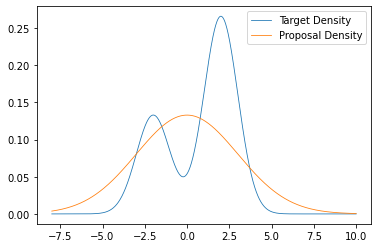

In [4]:
#Part B/ PART C

log_f = lambda y:np.log((1/3)*norm.pdf(x  = y, loc = -2, scale = 1) + 
                        (2/3)*norm.pdf(x = y, loc = 2, scale = 1))
log_g = lambda y: norm.logpdf(x= y, loc = 0, scale = 3)

x_values = np.linspace(start = -8, stop = 10, num = 1000)
funcs = np.exp(np.c_[log_f(x_values),log_g(x_values)])
logl1,logl2 = plt.plot(x_values, funcs, linewidth=0.8) 
plt.legend((logl1,logl2),('Target Density', 'Proposal Density'))
plt.show()

> e). Use the function you wrote ImpSampler( ), get the samples and the weights, 
compute the weighted average of the relevant h(.) functions and thus estimate $\mu_1$, $\mu_2$ and $\theta$. Use m = 5000 samples without any rejection control and report the 
estimated ESS from your runs. 

In [5]:
# Part E

proposer = lambda: norm.rvs(loc=0,scale=3,size=None)

null_samples , null_weights , null_eff = ImpSampler(nsamples = 5000,
                                                    logTarget = log_f,
                                                    logProposal = log_g,
                                                    proposal = proposer)
#calculate E(X), E(X^2) and E(e^X)
est_vals = np.array([np.sum(null_samples*null_weights),
                     np.sum((null_samples**2)*null_weights),
                     np.sum(np.exp(null_samples)*null_weights)])

#The actual values of these expectations, not the estimated ones
real_vals = np.array([2/3,5,(1/3)*np.exp(-3/2) + (2/3)*np.exp(5/2)])

print(f"The Estimated Values of our expected values are {est_vals.round(4)}")
print(f"The True Values of our expected values are {real_vals.round(4)}")
print(f"This is done with an effective sample size of {null_eff}")

The Estimated Values of our expected values are [0.7249 5.0122 8.333 ]
The True Values of our expected values are [0.6667 5.     8.196 ]
This is done with an effective sample size of 3214.0


> f).Now vary the rejection control constant  for $c \in \{1,2,\dots,10\}$. For each such c, as in the 
previous part, use the function you wrote ImpSampler( ) and estimate  $\mu_1$, $\mu_2$ and $\theta$ from m = 5000 samples with rejection control. For each c, report the estimated 
ESS (denoted by $e_c$), and the acceptance rate (denoted by $a_c$) of the samples from your runs. Let the error in the estimates be $|\hat \mu_1 - \mu_1|$, $|\hat \mu_2 - \mu_2|$ and $|\hat \theta - \theta|$. Finally, plot the three errors, ESS and acceptance rate against the rejection control constant (i.e. plot (c,$|\hat \mu_1 - \mu_1|$), (c,$|\hat \mu_2 - \mu_2|$), (c,$|\hat \theta - \theta|$), (c,$e_c$) and (c,$a_c$)).  Now share your 
observations on the error in the estimators, acceptance rate, ESS, 
recommendations on the choice of c. 


In [6]:
# Part F
c = 10
reported = [None]*c #store info

for i in range(c):
   draws,weights, ESS, a_c = ImpSampler(nsamples = 5000,logTarget = log_f,
                        logProposal = log_g,proposal = proposer,
                        ControlConstant = i+1 )
    
   est_vals = np.array([np.sum(draws*weights),
                        np.sum((draws**2)*weights),
                        np.sum(np.exp(draws)*weights)])

   error = np.abs(est_vals - real_vals)
   reported[i] = np.append(error,np.array([ESS,a_c])).round(3)   

#need to turn list to array
reported = np.array(reported)

#turns matrix to dataframe. index = rownames, columns = columns names
reported_df = pd.DataFrame(reported, 
                        index = ["c = " + str(j+1) for j in range(10)])

reported_df.columns = ['\u03BC 1 Error','\u03BC 2 Error','\u03B8 Error',
           "Effective Sample Size","Acceptance Rate"]

reported_df

,μ 1 Error,μ 2 Error,θ Error,Effective Sample Size,Acceptance Rate
c = 1,0.033,0.038,0.007,2994.0,0.686
c = 2,0.050,0.181,0.592,2309.0,0.466
c = 3,0.063,0.029,0.485,1663.0,0.333
c = 4,0.022,0.100,0.589,1238.0,0.248
c = 5,0.021,0.140,0.219,964.0,0.193
c = 6,0.149,0.023,0.512,874.0,0.175
c = 7,0.109,0.215,1.256,675.0,0.135
c = 8,0.061,0.279,0.734,616.0,0.123
c = 9,0.237,0.130,1.127,573.0,0.115
c = 10,0.069,0.220,0.308,484.0,0.097


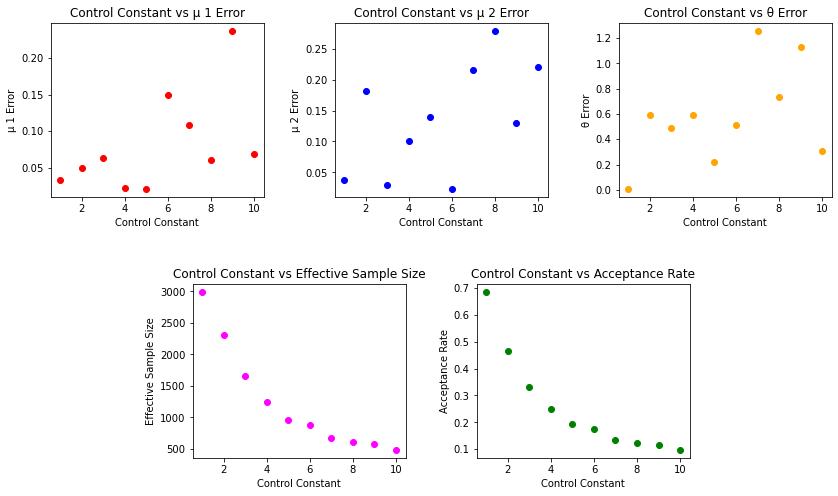

In [7]:
'NOTE: This portion needs to be run all at the same time'

#Sets up grid for our five figures
plt.figure(figsize=(14, 8)) #size of the figures

#locations of our grids into this shape
ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)

ax = [ax1,ax2,ax3,ax4,ax5]
col = ['red', 'blue','orange','magenta','green']

for j in range(5):
    ax[j].plot(range(1,c+1),reported[:,j],'o',color=col[j])
    ax[j].set_title('Control Constant' + ' vs ' + reported_df.columns[j])
    ax[j].set_xlabel("Control Constant")
    ax[j].set_ylabel(reported_df.columns[j])
plt.subplots_adjust(hspace=0.5, wspace=1)

### Problem 2: (BDA 3rd Ed. Exercise 10.5)
Rejection sampling and importance sampling: Consider the model, $y_j \sim Binomial(n_j , \theta_j )$,
where $\theta_j = logit^{-1}
(\alpha + \beta x_j )$, for $j = 1,\dots,J$, and with independent prior distributions,
$\alpha \sim t_4(0, 22)$ and $\beta \sim t_4(0, 1)$. Suppose $J = 10$, the $x_j$ values are randomly drawn from
a $Uniform(0, 1)$ distribution, and $n_j ∼ Poisson^{+}(5)$, where $Poisson^{+}$ is the Poisson distribution
restricted to positive values.


> (a) Sample a dataset at random from the model.

In [8]:
#PART A

#number of trials
J = 10
#having loc = 1 means we can't draw a zero
n = poisson.rvs(5, loc = 1, size = J, random_state = 123)
print(f"Our n values are {n}")
#initial pulls of our x's
x = uniform.rvs(size = J, random_state = 123 )
print(f"Our x values are {x.round(3)} ")
alpha_t = 2*t.rvs(df = 4, random_state = 123); beta_t = t.rvs(df=4, random_state=123)
y = binom.rvs(size = J, n = n, p =  1 / (np.exp(-alpha_t-beta_t*x) + 1), random_state=123)
print(f"Our y values are {y} ")

sim_data  = {'Trials': n,'Events': y,'Dose': x} 
sim_data = pd.DataFrame(sim_data)

Our n values are [ 8  6  5  9  5  9  8  6 10  5]
Our x values are [0.696 0.286 0.227 0.551 0.719 0.423 0.981 0.685 0.481 0.392] 
Our y values are [1 0 0 1 1 1 2 1 1 0] 


> (b) Use rejection sampling to get 1000 independent posterior draws from $(\alpha, \beta)$.

In [9]:
#PART B

t_prior = lambda x: t.pdf(x[0], df = 4,loc=0,scale=2)*t.pdf(x[1],loc=0,scale=1,df = 4)
#function of bioassay posterior,p(alpha,beta | y, n ,x)
def bioassay(z,data,prior):
    '''
    Parameters
    ----------
    z : input point (i.e. (alpha,beta) tuple)
    data : dataframe of simulated datapoints
    prior : prior function for this problem
    Returns
    -------
    logpost : natural log of unormalized density

    '''
    a,b = z[0], z[1]
    
    x,y,n = data['Dose'].to_numpy(),data['Events'].to_numpy(),data['Trials'].to_numpy()
    logprior = np.log(prior(z) )
    def loglik(a,b,x,y,n):
        theta = a+b*x
        return y*theta - n*np.log1p(np.exp(theta))
    logpost = logprior+sum(loglik(a,b,x[j],y[j],n[j]) for j in range(len(y)) )
    return logpost 

alphas = np.linspace(start = -7, stop = 5, num = 1000)
betas =  np.linspace(start = -10, stop = 10, num = 1000)

#logpost
logit_ = bioassay(z=list([alphas[:,None],betas[:,None,None]]),
                        data = sim_data,
                        prior = t_prior)

#turn log posterior back to posterior. subtract to avoid overflow
logit_ = logit_.sum(axis=2)
logit_ = np.exp(logit_ - logit_.max())

#Rejection Sampling Technique
w0 = np.array([0,0])
optim = optimize.minimize(lambda x: 
                               -(bioassay(x,data=sim_data,prior=t_prior)-
                                 np.log(t_prior(x)) ), w0)
M = (bioassay(optim['x'],data=sim_data,prior=t_prior)-np.log(t_prior(optim['x'])) )

num = 1000 #Number of Samples we want

post_samples = np.zeros((num,2))
counter = 0 # tells us when to stop
iters = 0 #tells us how many times we sample
while counter < num-1:
    draw = np.append(2*t.rvs(df=4), t.rvs(df=4))
    p = (bioassay(z=draw,data = sim_data,prior = t_prior) - np.log(t_prior(draw)) - M)
    if p > np.log(rand()):
        post_samples[counter,:] = draw
        counter +=1
    iters += 1
print(f"It took {iters} runs to get {num} samples")

It took 56856 runs to get 1000 samples


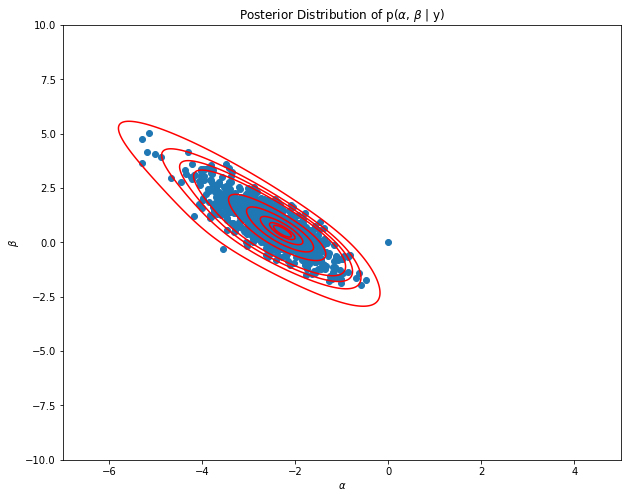

In [10]:
#plots contours and simulated points
plt.figure(figsize = (10, 8))
lev = [ 0.001, 0.01,.025,0.05,0.25,0.50,0.75,0.90,0.95]
cont = np.quantile(np.linspace(logit_.min(),logit_.max(),10000),lev)
plt.contour(alphas, betas, logit_, colors='red',levels=cont, zorder = 2)
plt.scatter(post_samples[:,0],post_samples[:,1])
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.title(r'Posterior Distribution of p($\alpha$, $\beta$ | y)')
plt.show()

> (c) Approximate the posterior density for  $(\alpha, \beta)$ by a normal centered at the posterior
mode with covariance matrix fit to the curvature at the mode

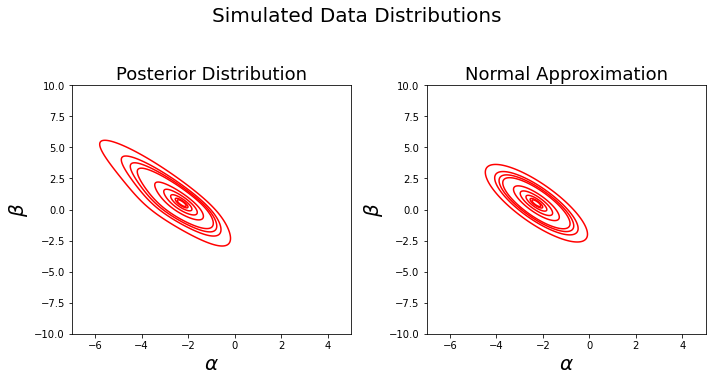

In [12]:
# PART C

# initial guess
w0 = np.array([0.0, 0.0])
# finds the mode and covariance matrix for normal approx
optim_norm = optimize.minimize(lambda x: -bioassay(x,data=sim_data,prior=t_prior), w0)
# extract desired results
norm_mu = optim_norm['x'];  norm_Sig = optim_norm['hess_inv']

#Now let's set up our multivariate normal
#Create grid and multivariate normal
A, B = np.meshgrid(alphas,betas)
pos = np.empty(A.shape + (2,))
pos[:, :, 0] = A; pos[:, :, 1] = B
norm_approx = multivariate_normal.pdf(x=pos, mean=norm_mu, cov=norm_Sig)
norm_cont = np.quantile(np.linspace(norm_approx.min(),norm_approx.max(),10000),lev)

fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(10,5))

#contour w/o replacement
ax1.contour(alphas,betas,logit_,levels=cont,colors='red')
ax1.set_ylabel(r'$\beta$', fontsize = 20)
ax1.set_xlabel( r'$\alpha$', fontsize = 20)
ax1.set_title('Posterior Distribution', fontsize = 18)

#contour w/ replacement
ax2.contour(alphas,betas,norm_approx,levels=norm_cont,colors='red')
ax2.set_ylabel(r'$\beta$', fontsize = 20)
ax2.set_xlabel( r'$\alpha$', fontsize = 20)
ax2.set_title('Normal Approximation', fontsize = 18)

fig.suptitle('Simulated Data Distributions', y = 1.05,fontsize=20)
fig.tight_layout()

> (d) Take 1000 draws from the two-dimensional $t_4$ distribution with that center and scale
matrix and use importance sampling to estimate $E(\alpha \mid y)$ and $E(\beta \mid y)$.

In [13]:
# PART D
param_stats(X = post_samples,p = [0.025,0.25,0.50,0.75,0.975],
            names = ['\u03B1','\u03B2'], sig = 2)
#We use the importance sampler function in [Problem 1] to solve d and e

mvt_samps = lambda : multivariate_t.rvs(loc=norm_mu, shape=norm_Sig, df=4, size=1)
post_target = lambda x: bioassay(x,data=sim_data,prior = t_prior)
post_proposal = lambda x: multivariate_t.pdf(x,loc=norm_mu, shape=norm_Sig, df=4)

#Importance Sampling
samps, weights, ESS = ImpSampler(nsamples = 1000, logTarget = post_target,
                            logProposal = post_proposal, proposal = mvt_samps)

print(f"Our Posterior mean E(\u03B1|y) = {np.round((samps[:,0]*weights).sum(),4)}")
print(f"Our Posterior mean E(\u03B2|y) = {np.round((samps[:,1]*weights).sum(),4)}")

Our Posterior mean E(α|y) = -2.326
Our Posterior mean E(β|y) = 0.5528


> (e) Compute an estimate of effective sample size for importance sampling using $S_{eff} = \frac{1}{\sum^{S}_{s=1}(\tilde{w}(\theta^{s}))^2}$, where $\tilde{w}(\theta^{s})= \frac{w(\theta^{s})}{\sum^{S}_{s'=1}(w(\theta^{s'})}$.

In [14]:
# PART E
print(f"Our Effective Sample Size is {ESS}")

Our Effective Sample Size is 720.0


### Problem 3: (BDA 3rd Ed., Exercise 10.8)
Importance resampling with and without replacement:

> (a) Consider the bioassay example introduced in Section 3.7. Use importance resampling
to approximate draws from the posterior distribution of the parameters $(\alpha, \beta)$, using
the normal approximation of Section 4.1 as the starting distribution. Sample $S = 10,000$ from the approximate distribution, and resample without replacement $k = 1000$ samples. Compare your simulations of $(\alpha, \beta)$ to Figure 3.3b and discuss any discrepancies.

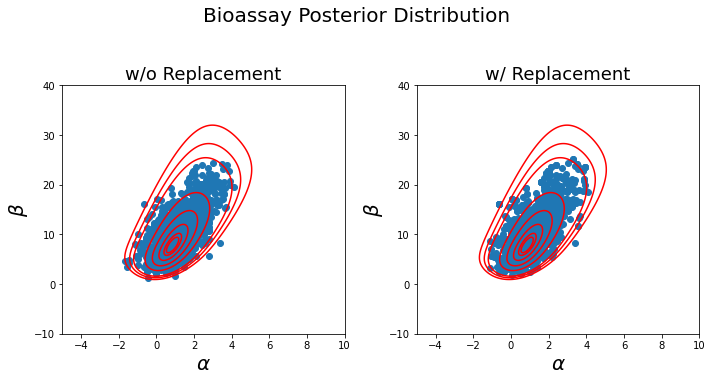

In [6]:
### PROBLEM 3 (BDA 3rd Ed, Exercise 10.8)

bioassay_data  = {
        'Trials': np.array([5,5,5,5]),
        'Events': np.array([0,1,3,5]),
        'Dose': np.array([-0.86,-0.30,-0.05,0.73])
                   } 

bioassay_data = pd.DataFrame(bioassay_data)

#function of bioassay posterior,p(alpha,beta | y, n ,x)
def bioassay(z,data,prior):
    '''
    Parameters
    ----------
    z : input point (i.e. (alpha,beta) tuple)
    data : dataframe of simulated datapoints
    prior : prior function for this problem
    Returns
    -------
    logpost : natural log of unormalized density

    '''
    a,b = z[0], z[1]
    
    x,y,n = data['Dose'].to_numpy(),data['Events'].to_numpy(),data['Trials'].to_numpy()
    logprior = np.log(prior(z) )
    def loglik(a,b,x,y,n):
        theta = a+b*x
        return y*theta - n*np.log1p(np.exp(theta))
    logpost = logprior+sum(loglik(a,b,x[j],y[j],n[j]) for j in range(len(y)) )
    return logpost 

#flat prior p(alpha,beta) propto 1
ind_prior = lambda x: 1

# initial guess
w0 = np.array([0.0, 0.0])
# optimise
optim_res = optimize.minimize(lambda x: -bioassay(x,data=bioassay_data,
                                              prior = ind_prior), w0)
# extract desired results
mu_w = optim_res['x']; I_w = optim_res['hess_inv'] 
np.linalg.eig(I_w)[0] #convince yourself I_w is positive definite

S = 10000
bio_target = lambda x: bioassay(x,data=bioassay_data,prior = ind_prior)
bio_proposal = lambda x: np.log(multivariate_normal.pdf(x, mean=mu_w, cov=I_w))
bio_proposer = lambda : multivariate_normal.rvs(mean=mu_w, cov=I_w, size = 1)
#importance re-sampling

#Importance Sampling
bio_samps, bio_wts, bio_ = ImpSampler(nsamples = S,logTarget = bio_target,
                            logProposal = bio_proposal, proposal = bio_proposer)

#This'll give us 1000 random draws
N1 = 1000
Picks_F = np.random.choice(S, size = N1,replace = False, p = bio_wts)
Picks_T = np.random.choice(S, size = N1,replace = True, p = bio_wts)

#new draws
alpha_draws_F, beta_draws_F = bio_samps[Picks_F,0], bio_samps[Picks_F,1]
alpha_draws_T, beta_draws_T = bio_samps[Picks_T,0], bio_samps[Picks_T,1]

#everything plotted on posterior
#Grid for plotting the unnormalized posterior
alpha_bio = np.linspace(start = -5, stop = 10, num = 1000)
beta_bio =  np.linspace(start = -10, stop = 40, num = 1000)

#logpost
bioassay_post = bioassay(z=list([alpha_bio[:,None],beta_bio[:,None,None]]),
                        data = bioassay_data,
                        prior = ind_prior)
#subtract to avoid overflow
bioassay_post = np.exp( np.sum(bioassay_post,axis=2)) 

#contour levels
biolev = [0.01,.025,0.05,0.25,0.50,0.75,0.90,0.95]
bio_cont = np.quantile(np.linspace(bioassay_post.min(),bioassay_post.max(),10000),biolev)

fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(10,5))

#contour w/o replacement
ax1.contour(alpha_bio,beta_bio,bioassay_post,levels=bio_cont,colors='red')
ax1.scatter(alpha_draws_F, beta_draws_F , zorder = 1)
ax1.set_ylabel(r'$\beta$', fontsize = 20)
ax1.set_ylim(-10,40)
ax1.set_xlabel( r'$\alpha$', fontsize = 20)
ax1.set_xlim(-5,10)
ax1.set_title('w/o Replacement', fontsize = 18)

#contour w/ replacement
ax2.contour(alpha_bio,beta_bio,bioassay_post,levels=bio_cont,colors='red')
ax2.scatter(alpha_draws_T, beta_draws_T, zorder = 1)
ax2.set_ylabel(r'$\beta$', fontsize = 20)
ax2.set_ylim(-10,40)
ax2.set_xlabel( r'$\alpha$', fontsize = 20)
ax2.set_xlim(-5,10)
ax2.set_title('w/ Replacement', fontsize = 18)

fig.suptitle('Bioassay Posterior Distribution', y = 1.05,fontsize=20)
fig.tight_layout()

> (b) Comment on the distribution of the simulated importance ratios.

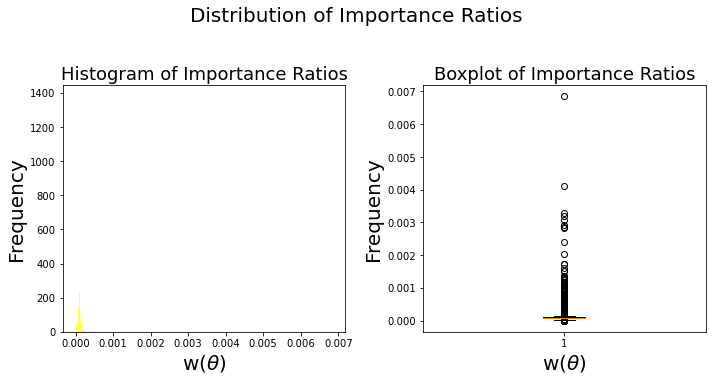

In [9]:
fig, (ax3,ax4) = plt.subplots(1, 2,figsize=(10,5))

#Histogram for distirbution of wts
ax3.hist(x = bio_wts, bins='auto', color='yellow', alpha=0.7)
ax3.set_ylabel('Frequency', fontsize = 20)
ax3.set_xlabel(r'w($\theta$)', fontsize = 20)
ax3.set_title('Histogram of Importance Ratios', fontsize = 18)

#Boxplot for distirbution of wts
ax4.boxplot(x = bio_wts)
ax4.set_ylabel('Frequency', fontsize = 20)
ax4.set_xlabel(r'w($\theta$)', fontsize = 20)
ax4.set_title('Boxplot of Importance Ratios', fontsize = 18)

fig.suptitle('Distribution of Importance Ratios', y = 1.05,fontsize=20)
fig.tight_layout()

### PROBLEM 4: (BDA 3rd Ed., Exercise 11.2)
Metropolis algorithm: Replicate the computations for the bioassay example of Section 3.7
using the Metropolis algorithm. Be sure to define your starting points and your jumping
rule. Compute with log-densities (see page 261). Run the simulations long enough for
approximate convergence.

Define the posterior distribution

In [11]:
### Problem 4 (BDA 3rd Ed, Exercise 11.2)

bioassay_data  = {
        'Trials': np.array([5,5,5,5]),
        'Events': np.array([0,1,3,5]),
        'Dose': np.array([-0.86,-0.30,-0.05,0.73])
                   } 

#turns data from dictionary format to dataframe format
bioassay_data = pd.DataFrame(bioassay_data)

# uniform prior for this problem
ind_prior = lambda x: 1

#function of bioassay posterior,p(alpha,beta | y, n ,x)
def bioassay(z,data,prior):
    '''
    Parameters
    ----------
    z : input point (i.e. (alpha,beta) tuple)
    data : dataframe of simulated datapoints
    prior : prior function for this problem
    Returns
    -------
    logpost : natural log of unormalized density

    '''
    #The function is written like this so we can generalize to grid sampling,
    #and so that we can plug in points
    a,b = z[0], z[1]
    
    #make it easier to write function. .to_numpy() turns dataframe column to numpy array
    x,y,n = data['Dose'].to_numpy(),data['Events'].to_numpy(),data['Trials'].to_numpy()
    
    #putting prior in log format
    logprior = np.log(prior(z) )
    
    #log liklihood function
    def loglik(a,b,x,y,n):
        return y*(a+b*x) - n*np.log1p(np.exp(a+b*x))
    
    #natural log of the posterior = log of prior + log-liklihood
    logpost = logprior+sum(loglik(a,b,x[j],y[j],n[j]) for j in range(len(y)) )
    return logpost 

We use a normal distribution for our jumping distribution. Therefore here we find what the mean and covariance of that distribution should be

In [12]:
### GET MAP for this posterior, and also get the Inverse Fisher info associated with it.

# initial guess
w0 = np.array([0.0, 0.0])
# optimise (NOTE: This only minimizes so we make it negative to maximize)
optim_res = optimize.minimize(lambda x: -bioassay(x,data=bioassay_data,
                                              prior = ind_prior), w0)

# extract desired results
mu_w = optim_res['x']; I_w = optim_res['hess_inv'] 

np.linalg.eig(I_w)[0] #convince yourself I_w is positive definite (pos def means it's a max)
print(f"The mode of our posterior is {mu_w}")
print(f"The Fisher Information (Covariance Matrix) associated with the mode is {I_w}")

The mode of our posterior is [0.84658517 7.74883075]
The Fisher Information (Covariance Matrix) associated with the mode is [[ 0.96949024  3.4468913 ]
 [ 3.4468913  23.51510283]]


Metropolis-Hastings Algorithm

In [13]:
### METROPOLIS HASTINGS ALGORITHM

init = mu_w # initial starting position

# do this externally so we don't have to continuously do it in the loop process
r_bottom = bioassay(z = init, data = bioassay_data, prior = ind_prior)

c = 2.4 / np.sqrt(2) # variance scaling parameter. improves sampling
D = 50000 # number of samples to draw
u = np.log( rand(D) ) # on log scale. Calling outside loop saves time.
count = 0 # used to count the number of acceptances
MC  = [None]*D #pre-allocating space will save you precious computational time

# records speed
t1 = time.time()

for i in range(D):
     
    #sample proposal theta* using jumping distribution J_t(theta* | theta^{t-1})
    #here, proposal = theta*, and theta^{t-1} = init

    proposal = multivariate_normal(mean=init, cov=(c**2)*I_w).rvs()
    
    '''calculate log ratio of densities where the ratio is
    r = [ p(theta* | y)/J_t(theta* | theta^{t-1}) ] / [ p(theta^{t-1} | y)/J_t(theta^{t-1} | theta*) ].
    NOTE: For metropolis hastings, the jumping rule need not be symmetric
    '''

    r_top = bioassay(z = proposal, data = bioassay_data, prior = ind_prior)
    
    r = min(r_top-r_bottom,0) #use this to accept or reject
    
    #if r > u, accept. otherwise reject
    if r > u[i]:
        init = proposal
        r_bottom = r_top #explained above
        count += 1 #counts the number of samples that we've accepted
    MC[i] = init #regardless of accept/reject, append this to your samples
    
t2 = time.time()

#This is called an "f string". Superior printing for when you have numbers to include
print(f"It took about {t2-t1} seconds to perform the MH algorithm")
print(f"Our acceptance rate is {100*count / D}%")

MC = np.array(MC) #turns from list to array (must be array to do plotting)

It took about 48.912790060043335 seconds to perform the MH algorithm
Our acceptance rate is 38.634%


Trace Plots

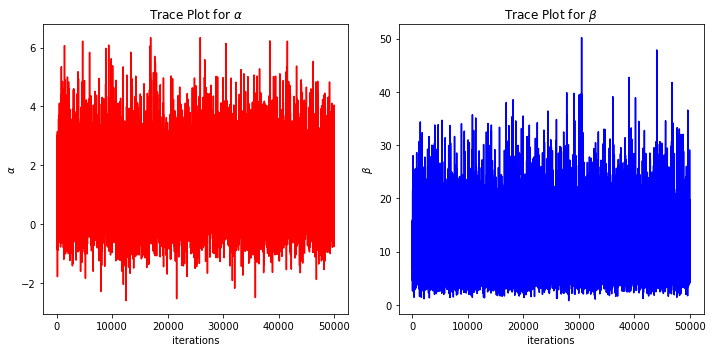

In [14]:
## Trace plots
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(10,5))

ax = [ax1,ax2]
MH_parameters = [r'$\alpha$', r'$\beta$']
MH_colors = ['red','blue']
for j in range(2):
    plt.tight_layout()
    ax[j].plot(np.arange(0,D), MC[:,j],color=MH_colors[j])
    ax[j].set_title('Trace Plot for ' + MH_parameters[j])
    ax[j].set_xlabel('iterations')
    ax[j].set_ylabel(MH_parameters[j])
fig.tight_layout()

Cumulative Average Plots (Mean Plots)

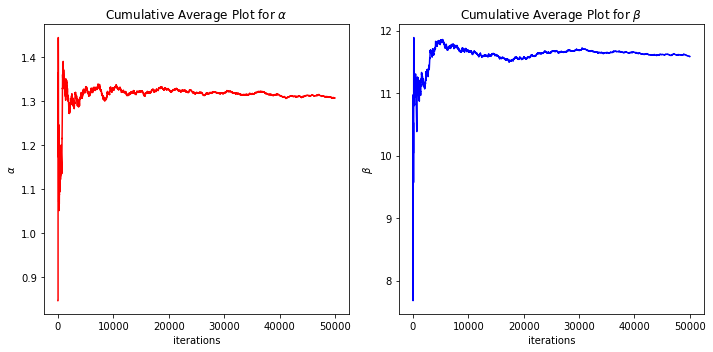

In [15]:
## Mean Plots
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(10,5))

ax = [ax1,ax2]
for j in range(2):
    plt.tight_layout()
    ax[j].plot(np.arange(0,D), np.cumsum(MC[:,j])/np.arange(1,D+1),color=MH_colors[j])
    ax[j].set_title('Cumulative Average Plot for ' + MH_parameters[j])
    ax[j].set_xlabel('iterations')
    ax[j].set_ylabel(MH_parameters[j])
fig.tight_layout()

Autocorrelation Plots

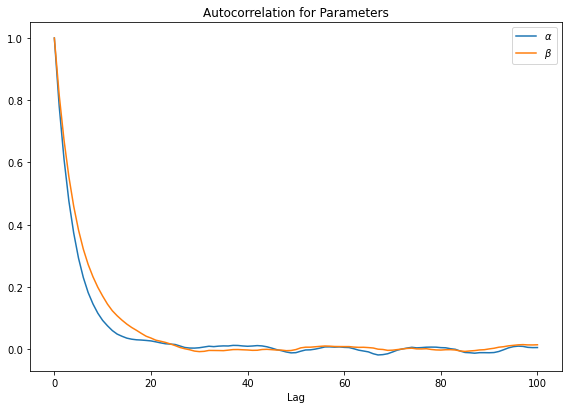

In [33]:
## Autocorrelation plots

fig = plt.figure(figsize=(8, 16))
ax1 = fig.add_subplot(3, 1, 3)
maxlag = 100 # maximum lag for autocorrelation
sampsc = MC - MC.mean(axis=0) # scale the samples by subtracting the mean
acorlags = np.arange(maxlag+1) # lags from 0 to maxlag

# calculate autocorrelation for all different lags
for i in range(2):
    auto = np.correlate(sampsc[:,i], sampsc[:,i], mode = 'full') 
    auto = auto[-len(sampsc):-len(sampsc)+maxlag+1] / auto[-len(sampsc)] 
    ax1.plot(acorlags, auto)
ax1.set_xlabel('Lag')
ax1.set_title('Autocorrelation for Parameters')
ax1.legend([r'$\alpha$',r'$\beta$'])
fig.tight_layout()

Posterior Distribution with Posterior samples from the Metropolis Hastings Run

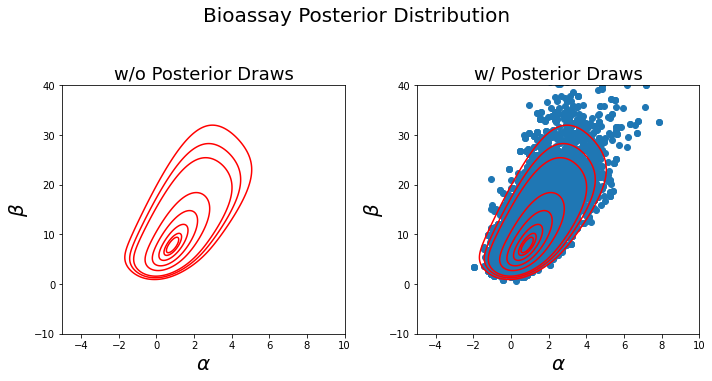

In [37]:
#accepted samples (throws away the first 60%, considered here to be burnin)
accepted_bio = MC[-int(0.4*D):,]

# range for the grid to sample from
alpha_bio = np.linspace(start = -5, stop = 10, num = 1000)
beta_bio =  np.linspace(start = -10, stop = 40, num = 1000)

#logpost
logit_ = bioassay(z=list([alpha_bio[:,None],beta_bio[:,None,None]]),
                        data = bioassay_data,
                        prior = ind_prior)

#turn log posterior back to posterior. subtract to avoid overflow
logit_ = logit_.sum(axis=2)
logit_ = np.exp(logit_ - logit_.max())


#contour levels
biolev = [0.01,.025,0.05,0.25,0.50,0.75,0.90,0.95]
bio_cont = np.quantile(np.linspace(logit_.min(),logit_.max(),10000),biolev)

fig, (ax2,ax3) = plt.subplots(1, 2,figsize=(10,5))

#contour w/o samples
ax2.contour(alpha_bio,beta_bio,logit_,levels=bio_cont,colors='red')
ax2.set_ylabel(r'$\beta$', fontsize = 20)
ax2.set_ylim(-10,40)
ax2.set_xlabel( r'$\alpha$', fontsize = 20)
ax2.set_xlim(-5,10)
ax2.set_title('w/o Posterior Draws', fontsize = 18)

#contour w samples
ax3.contour(alpha_bio,beta_bio,logit_,levels=bio_cont,colors='red')
ax3.scatter(accepted_bio[:,0], accepted_bio[:,1] , zorder = 1)
ax3.set_ylabel(r'$\beta$', fontsize = 20)
ax3.set_ylim(-10,40)
ax3.set_xlabel( r'$\alpha$', fontsize = 20)
ax3.set_xlim(-5,10)
ax3.set_title('w/ Posterior Draws', fontsize = 18)

fig.suptitle('Bioassay Posterior Distribution', y = 1.05,fontsize=20)
fig.tight_layout()

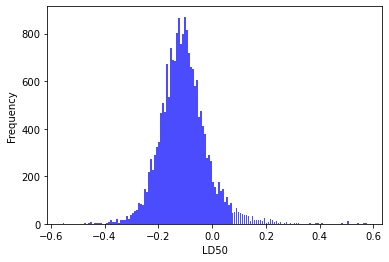

In [38]:
#LD50 plot
plt.hist(x = -accepted_bio[:,0]/accepted_bio[:,1], 
         bins='auto', color='blue', alpha=0.7, rwidth=0.85)
plt.ylabel('Frequency')
plt.xlabel("LD50")
plt.show()

### PROBLEM 5 (BDA 3rd Ed., Exercise 11.3)
Gibbs sampling: Table 11.4 contains quality control measurements from 6 machines in
a factory. Quality control measurements are expensive and time-consuming, so only 5
measurements were done for each machine. In addition to the existing machines, we
are interested in the quality of another machine (the seventh machine). Implement a separate, a pooled and hierarchical Gaussian model with common variance described in
Section 11.6. Run the simulations long enough for approximate convergence. Using each
of three models—separate, pooled, and hierarchical—report: (i) the posterior distribution of the mean of the quality measurements of the sixth machine, (ii) the predictive
distribution for another quality measurement of the sixth machine, and (iii) the posterior
distribution of the mean of the quality measurements of the seventh machine.

In [39]:
### PROBLEM 5 (BDA 3rd Ed., Exercise 11.3)

machine = { 'Machine 1': np.array([83,92,92,46,67]),
      'Machine 2':np.array([117,109,114,104,87]),
      'Machine 3': np.array([101,93,92,86,67]),
      'Machine 4': np.array([105,119,116,102,116]),
      'Machine 5':np.array([79,97,103,79,92]),
      'Machine 6':np.array([57,92,104,77,100])
      }

#statistics about the data
machine_n = np.array([len(x) for x in machine.values()])
machine_mean = np.array([(x).mean() for x in machine.values()])
machine_var = np.array([(x).var(ddof=1) for x in machine.values()])

## Pooled Model

In [40]:
### (i) Pooled Model

pooled = np.concatenate(list(machine.values())).ravel()
pooled_var = pooled.var(ddof=1)
pooled_mean = pooled.mean()

B = 1000

#marginal posterior pdf's for mu and sigma.
sig_pooled = np.sqrt( (len(pooled)-1)*pooled_var / (chi2.rvs(df = len(pooled) - 1, size = B)) )
theta_pooled = norm.rvs(loc = pooled_mean, scale = sig_pooled/len(pooled))

param_stats(X = np.c_[theta_pooled,sig_pooled],p = [0.025,0.25,0.50,0.75,0.975],
                       names = ['\u03B8','\u03C3'], sig = 2)

,Mean,Standard Deviation,2.5%,25.0%,50.0%,75.0%,97.5%
θ,92.94,0.62,91.77,92.55,92.92,93.32,94.11
σ,18.61,2.50,14.48,16.78,18.28,20.12,23.87


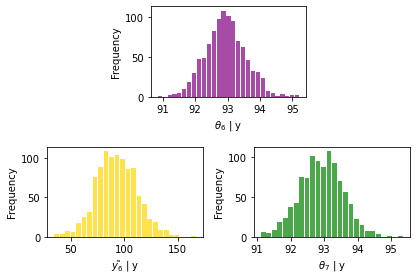

In [43]:
#Histograms of theta_6 |y, tilde y_6 | y, and theta_7 | y.

pooled_hist = np.c_[theta_pooled,
                    norm.rvs(loc = theta_pooled, scale = sig_pooled),
                    norm.rvs(loc = pooled_mean, scale = sig_pooled/len(pooled))]

#Sets up grid for our three figures
ax1 = plt.subplot2grid(shape=(4,4), loc=(0,1), colspan=2,rowspan = 2)
ax2 = plt.subplot2grid((4,4), (2,0), colspan=2,rowspan = 2)
ax3 = plt.subplot2grid((4,4), (2,2), colspan=2,rowspan = 2)

ax = [ax1,ax2,ax3]
col = ['purple', 'gold','green']
posterior_labels = [r'$\theta_6$ | y',r'$\tilde{y_6}$ | y',r'$\theta_7$ | y']

for j in range(3):
    plt.tight_layout()
    ax[j].hist(x = pooled_hist[:,j],bins='auto', color=col[j], alpha=0.7, rwidth=0.85)
    ax[j].set_ylabel("Frequency")
    ax[j].set_xlabel(posterior_labels[j])

## Separate Model

In [42]:
### (ii) Separate Model

sig_sep = np.sqrt( sum( (machine_n-1)*machine_var ) / chi2.rvs(size=B,df = sum(machine_n) ))
theta_sep = [norm.rvs(loc = np.mean(x), scale = sig_sep/len(x), size = B) 
             for x in machine.values()]

theta_sep = np.array(theta_sep).T

sep_names =  np.concatenate([['\u03B8'+str(j) for j in range(1,len(machine_n)+1)],
         ['\u03C3']])

param_stats(X = np.c_[theta_sep,sig_sep],p = [0.025,0.25,0.50,0.75,0.975],
                       names = sep_names, sig = 2)

,Mean,Standard Deviation,2.5%,25.0%,50.0%,75.0%,97.5%
θ1,75.92,2.50,71.13,74.27,75.95,77.62,81.11
θ2,106.19,2.70,100.72,104.39,106.20,107.93,111.52
θ3,87.80,2.56,82.51,86.18,87.87,89.50,92.89
θ4,111.67,2.63,106.45,109.93,111.67,113.31,116.85
θ5,90.06,2.73,84.51,88.23,90.04,91.93,95.31
θ6,86.00,2.69,80.48,84.31,86.05,87.77,91.33
σ,13.17,1.81,10.30,11.93,12.95,14.23,17.19


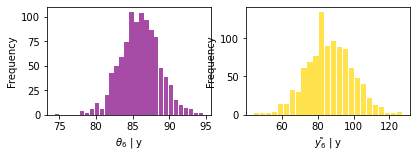

In [44]:
#Histograms of theta_6 |y, tilde y_6 | y, and theta_7 | y.

sep_hist = np.c_[theta_sep[:,5],
                 norm.rvs(loc = theta_sep[:,5], scale = sig_sep)]

#Sets up grid for our three figures
ax1 = plt.subplot2grid((4,4), (2,0), colspan=2,rowspan = 2)
ax2 = plt.subplot2grid((4,4), (2,2), colspan=2,rowspan = 2)

ax = [ax1,ax2]

for j in range(2):
    plt.tight_layout()
    ax[j].hist(x = sep_hist[:,j],bins='auto', color=col[j], alpha=0.7, rwidth=0.85)
    ax[j].set_ylabel("Frequency")
    ax[j].set_xlabel(posterior_labels[j])

## Hierarchical

In [45]:
###  (iii) Hierarchical Model
N5 = 50000 #How many values we want to draw up

#list to append our samples to
theta_gibbs = [None]*N5
sigma_gibbs = [None]*N5
mu_gibbs = [None]*N5
tau_gibbs = [None]*N5
#initial values
theta = np.array([72,75,87,91,69,73])
mu = theta.mean()

#helpful things
J = len(theta)

t1 = time.time()
for j in range(N5):
    
    # Sigma draws
    s2 = machine_n*(machine_mean - theta)**2 + (machine_n - 1)*machine_var 
    sigma = np.sqrt( s2.sum() / chi2.rvs(df = machine_n.sum() ))
    sigma_gibbs[j] = sigma
    
    # Tau draw
    tau = np.sqrt( ((theta - mu)**2).sum() / chi2.rvs(df = J - 1) )
    tau_gibbs[j] = tau

    # Theta draws
    V = 1 / ( (1/tau)**2 + (machine_n/(sigma**2)) )
    theta_hat = ((1/tau**2)*mu + (1/sigma**2)*(machine_mean*machine_n))*V
    theta = norm.rvs(loc = theta_hat, scale = np.sqrt(V))
    theta_gibbs[j] = theta
    
    # Mu Draw
    mu = norm.rvs(loc = theta.mean(), scale = tau / np.sqrt(J) )
    mu_gibbs[j] = mu
    
t2 = time.time()
print(f"It took approximately {round(t2-t1,4)} seconds for this to run {N5} samples")

theta_gibbs = np.array(theta_gibbs)
sigma_gibbs = np.array(sigma_gibbs)
mu_gibbs = np.array(mu_gibbs)
tau_gibbs = np.array(tau_gibbs)

P5_gibbs = np.c_[theta_gibbs,sigma_gibbs,mu_gibbs,tau_gibbs]
P5_titles = np.concatenate([['\u03B8'+str(j) for j in range(1,7)],
                         ['\u03C3','\u03BC','\u03C4'],])

param_stats(X = P5_gibbs[-int(0.4*N5):,] ,
            p = [0.025,0.25,0.50,0.75,0.975], 
            names = P5_titles, sig = 2)

It took approximately 14.3832 seconds for this to run 50000 samples


,Mean,Standard Deviation,2.5%,25.0%,50.0%,75.0%,97.5%
θ1,79.79,6.78,66.89,75.22,79.67,84.13,93.84
θ2,103.20,6.45,90.41,98.88,103.19,107.50,115.78
θ3,88.93,6.11,76.87,84.81,89.03,93.00,100.91
θ4,107.36,6.96,93.38,102.82,107.54,112.05,120.74
θ5,90.65,6.04,78.61,86.68,90.73,94.65,102.40
θ6,87.57,6.17,75.33,83.49,87.66,91.71,99.55
σ,14.93,2.29,11.23,13.31,14.66,16.24,20.23
μ,92.87,8.37,76.26,88.50,92.86,97.27,109.25
τ,16.34,10.12,4.01,10.31,14.15,19.74,40.92


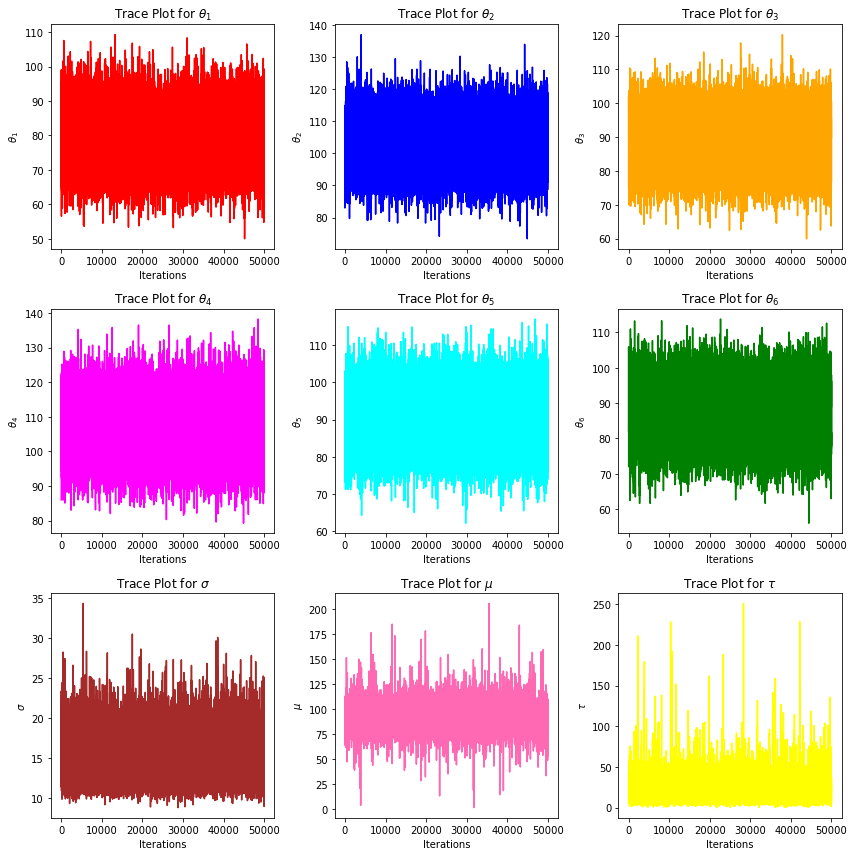

In [46]:
iters = np.arange(0, N5+1)

# Trace Plots
colors = ['red', 'blue','orange','magenta','cyan','green',
          'brown','hotpink','yellow']
theta_titles = [r'$\theta_1$',r'$\theta_2$',r'$\theta_3$',
          r'$\theta_4$',r'$\theta_5$',r'$\theta_6$',
          r'$\sigma$',r'$\mu$',r'$\tau$']

f,a = plt.subplots(3,3, figsize = (12,12))
a = a.ravel()
for idx,ax in enumerate(a):
    plt.tight_layout()
    ax.plot(P5_gibbs[:,idx], color = colors[idx])
    ax.set_title('Trace Plot for' + ' ' + theta_titles[idx])
    ax.set_xlabel("Iterations")
    ax.set_ylabel(theta_titles[idx])

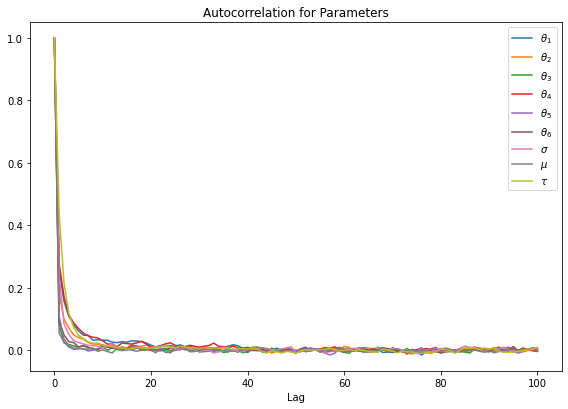

In [47]:
## Autocorrelation plots

fig = plt.figure(figsize=(8, 16))
ax1 = fig.add_subplot(3, 1, 3)
maxlag = 100 # maximum lag for autocorrelation
sampsc = P5_gibbs - P5_gibbs.mean(axis=0) # scale the samples by subtracting the mean
acorlags = np.arange(maxlag+1) # lags from 0 to maxlag

# calculate autocorrelation for all different lags
for i in range(P5_gibbs.shape[1]):
    auto = np.correlate(sampsc[:,i], sampsc[:,i], mode = 'full') 
    auto = auto[-len(sampsc):-len(sampsc)+maxlag+1] / auto[-len(sampsc)] 
    ax1.plot(acorlags, auto)
ax1.set_xlabel('Lag')
ax1.set_title('Autocorrelation for Parameters')
ax1.legend(theta_titles)
fig.tight_layout()

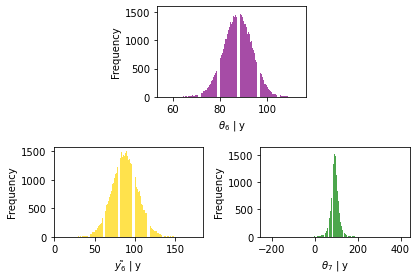

In [48]:
#Histograms of theta_6 |y, tilde y_6 | y, and theta_7 | y.

hier_hist = np.c_[theta_gibbs[:,5],
                    norm.rvs(loc = theta_gibbs[:,5], scale = sigma_gibbs),
                    norm.rvs(loc = mu_gibbs, scale = tau_gibbs)]

#Sets up grid for our three figures
ax1 = plt.subplot2grid(shape=(4,4), loc=(0,1), colspan=2,rowspan = 2)
ax2 = plt.subplot2grid((4,4), (2,0), colspan=2,rowspan = 2)
ax3 = plt.subplot2grid((4,4), (2,2), colspan=2,rowspan = 2)

ax = [ax1,ax2,ax3]

for j in range(3):
    plt.tight_layout()
    ax[j].hist(x = hier_hist[:,j],bins='auto', color=col[j], alpha=0.7, rwidth=0.85)
    ax[j].set_ylabel("Frequency")
    ax[j].set_xlabel(posterior_labels[j])

### PROBLEM 6 (BDA 3rd Ed., Exercise 11.4)
Gibbs sampling: Extend the model in Exercise 11.3 by adding a hierarchical model for
the variances of the machine quality measurements. Use an $Inv-\chi^{2}$ prior distribution
for variances with unknown scale $\sigma_0^{2}$
 and fixed degrees of freedom. (The data do not
contain enough information for determining the degrees of freedom, so inference for
that hyperparameter would depend very strongly on its prior distribution in any case).
The conditional distribution of $\sigma_0^{2}$ is not of simple form, but you can sample from its
distribution, for example, using grid sampling.

In [50]:
### PROBLEM 6 (BDA 3rd Ed., Exercise 11.4)

N6 = 50000 #How many values we want to draw up

machine = { 'Machine 1': np.array([83,92,92,46,67]),
      'Machine 2':np.array([117,109,114,104,87]),
      'Machine 3': np.array([101,93,92,86,67]),
      'Machine 4': np.array([105,119,116,102,116]),
      'Machine 5':np.array([79,97,103,79,92]),
      'Machine 6':np.array([57,92,104,77,100])
      }

#statistics about the data
machine_n = np.array([len(x) for x in machine.values()])
machine_mean = np.array([(x).mean() for x in machine.values()])
machine_var = np.array([(x).var(ddof=1) for x in machine.values()])

#list to append our samples to
P6_theta_gibbs = [None]*N6
P6_sigma_gibbs = [None]*N6
P6_mu_gibbs = [None]*N6
P6_tau_gibbs = [None]*N6
P6_sig0_gibbs = [None]*N6

#initial values
theta = np.array([72,75,87,91,69,73])
sig0 = 12
mu = theta.mean()
nu = 3

#Functions for sig0 pdf 
def sig0_pdf(x,df,s,J): 
     p = ((J*df)/2 - 1)*np.log(x) - ( (df*x)/2)*sum(1/s**2)
     return p
 
#Grid for sigma 0 
sig2_0_grid = np.linspace(start = 1, stop = 500, num = 2000)
d_sig0 = np.diff(sig2_0_grid)[0]/2

#helpful things
J = len(theta)

t3 = time.time()
for j in range(N5):
    
    # Sigma draws
    big = machine_n*(machine_mean - theta)**2 + (machine_n - 1)*machine_var
    sigma_hat_sq = (nu*sig0**2 + big ) 
    sigma = np.sqrt(sigma_hat_sq / chi2.rvs(df = nu +  machine_n ))
    P6_sigma_gibbs[j] = sigma
    
    # sig_0 draws
    sig2_0_pdf = sig0_pdf(x=sig2_0_grid,df = nu,s = sigma, J = 5)
    sig2_0_pdf = np.exp(sig2_0_pdf) / (np.exp(sig2_0_pdf)).sum()
    sig0 = np.sqrt( np.random.choice(sig2_0_grid,p = sig2_0_pdf) + (d_sig0)*rand() )
    P6_sig0_gibbs[j] = sig0

    # Tau draw
    tau_hat_sq = ((theta - mu)**2).sum()
    tau = np.sqrt( tau_hat_sq / chi2.rvs(df = J - 1) )
    P6_tau_gibbs[j] = tau
    
    # Theta draws
    V = 1 / ((1/tau)**2 + (machine_n/(sigma**2)))
    theta_hat = ((mu / tau**2) + ( (machine_mean*machine_n)/sigma**2))*V
    theta = norm.rvs(loc = theta_hat, scale = np.sqrt(V))
    P6_theta_gibbs[j] = theta
    
    # Mu Draw
    mu = stats.norm.rvs(loc = theta.mean(), scale = np.sqrt(tau**2 / J))
    P6_mu_gibbs[j] = mu
    
t4 = time.time()
print(f"It took approximately {round(t4-t3,4)} seconds for this to run {N5} samples")

It took approximately 25.1213 seconds for this to run 50000 samples


In [51]:
#turns list into arrays
P6_theta_gibbs = np.array(P6_theta_gibbs)
P6_sigma_gibbs = np.array(P6_sigma_gibbs)
P6_mu_gibbs = np.array(P6_mu_gibbs)
P6_tau_gibbs = np.array(P6_tau_gibbs)
P6_sig0_gibbs = np.array(P6_sig0_gibbs)

#combine to make it easier to calculate statistics
P6_gibbs = np.c_[P6_theta_gibbs,P6_sigma_gibbs,P6_mu_gibbs,P6_tau_gibbs,P6_sig0_gibbs]
P6_hyper_gibbs = np.c_[P6_mu_gibbs,P6_tau_gibbs,P6_sig0_gibbs]

P6_titles = np.concatenate([['\u03B8'+str(j) for j in range(1,7)],
                            ['\u03C3'+str(j) for j in range(1,7)],
                            ['\u03BC','\u03C4','\u03C3'+str(0)]])

param_stats(X = P6_gibbs[-int(0.4*N6):,],
            p = [0.025,0.25,0.50,0.75,0.975], 
            names = P6_titles, sig = 2)

,Mean,Standard Deviation,2.5%,25.0%,50.0%,75.0%,97.5%
θ1,80.94,8.33,64.92,75.45,80.75,86.24,98.02
θ2,104.10,5.73,92.22,100.58,104.30,107.80,115.02
θ3,88.94,5.73,77.67,85.39,88.91,92.47,100.54
θ4,109.20,5.35,97.13,106.29,109.63,112.62,118.74
θ5,90.59,5.27,80.09,87.32,90.56,93.78,101.33
θ6,88.03,7.40,73.33,83.30,88.05,92.70,102.71
σ1,19.03,6.26,10.98,14.76,17.76,21.74,34.51
σ2,12.99,4.28,7.36,10.05,12.12,14.98,23.77
σ3,13.46,4.29,7.78,10.50,12.63,15.42,24.14
σ4,10.76,4.11,5.70,8.01,9.90,12.46,21.05


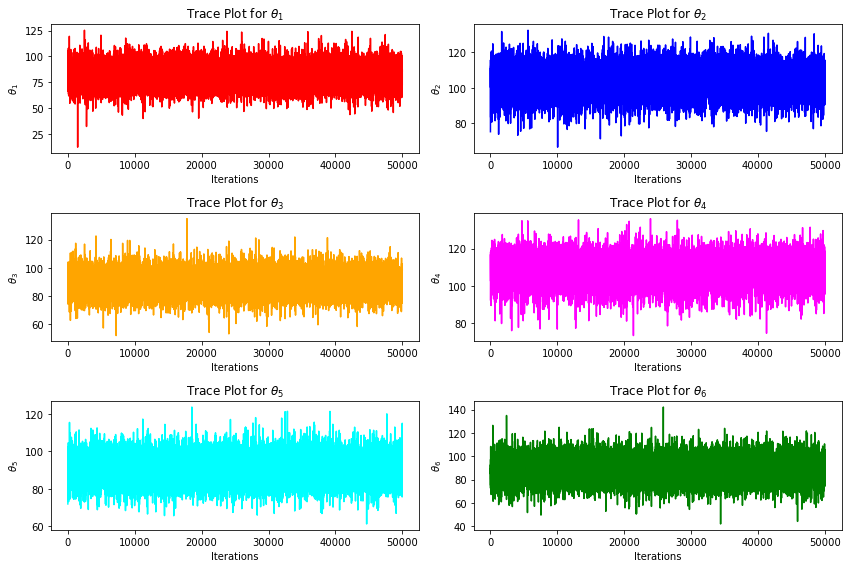

In [52]:
#Trace plots

#our iterations
iters = np.arange(0, N6+1)

colors = ['red', 'blue','orange','magenta','cyan','green']
theta_titles = [r'$\theta_1$',r'$\theta_2$',r'$\theta_3$',
          r'$\theta_4$',r'$\theta_5$',r'$\theta_6$']
sigma_titles = [r'$\sigma_1$',r'$\sigma_2$',r'$\sigma_3$',
          r'$\sigma_4$',r'$\sigma_5$',r'$\sigma_6$']
hyper_titles = [r'$\mu$',r'$\sigma_0$',r'$\tau$']
hyper_colors = ['yellow', 'purple','green']

f,a = plt.subplots(3,2, figsize = (12,8))
a = a.ravel()
for idx,ax in enumerate(a):
    plt.tight_layout()
    ax.plot(P6_theta_gibbs[:,idx], color = colors[idx])
    ax.set_title('Trace Plot for' + ' ' + theta_titles[idx])
    ax.set_xlabel("Iterations")
    ax.set_ylabel(theta_titles[idx])

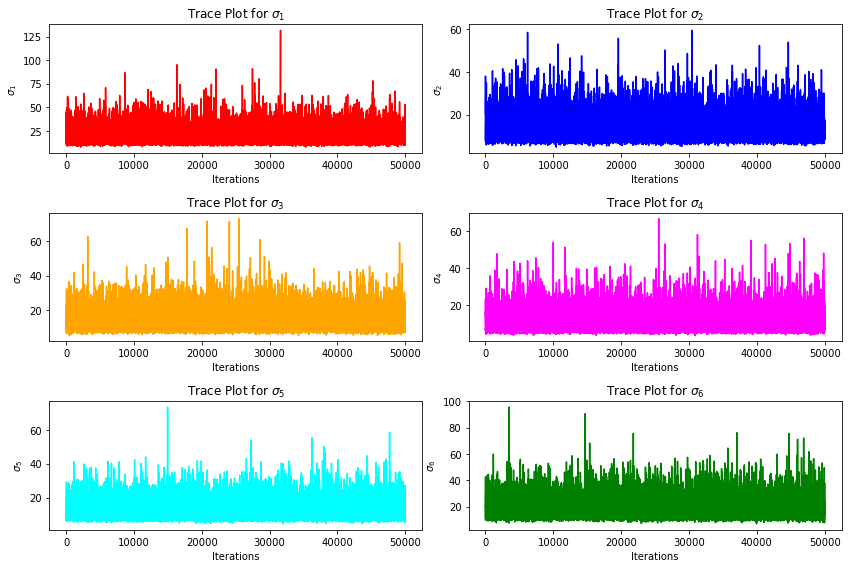

In [53]:
# Sigma Trace Plots
f,a = plt.subplots(3,2, figsize = (12,8))
a = a.ravel()
for idx,ax in enumerate(a):
    plt.tight_layout()
    ax.plot(P6_sigma_gibbs[:,idx], color = colors[idx])
    ax.set_title('Trace Plot for' + ' ' + sigma_titles[idx])
    ax.set_xlabel("Iterations")
    ax.set_ylabel(sigma_titles[idx])

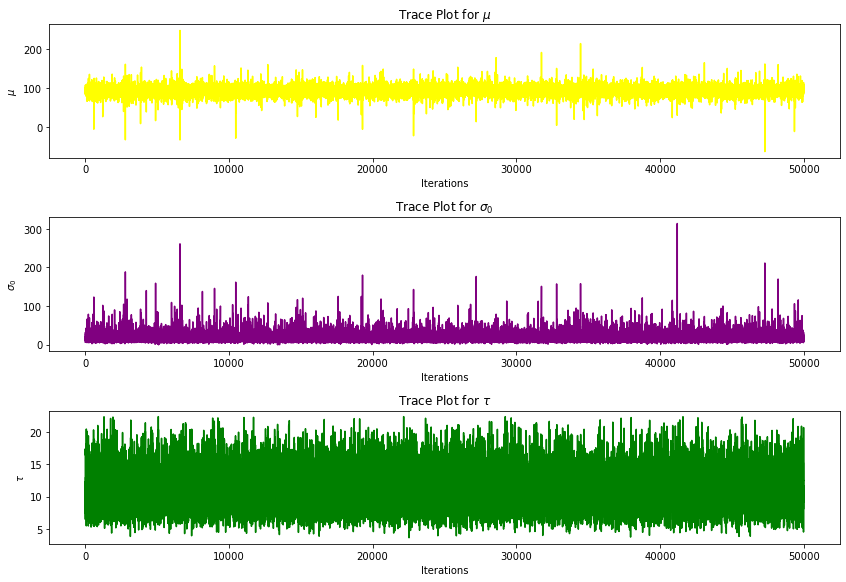

In [54]:
#Hyperparameter Trace plots
f,a = plt.subplots(3,1,figsize = (12,8))
a = a.ravel()
for idx,ax in enumerate(a):
    plt.tight_layout()
    ax.plot(P6_hyper_gibbs[:,idx], color = hyper_colors[idx])
    ax.set_title('Trace Plot for' + ' ' + hyper_titles[idx])
    ax.set_xlabel("Iterations")
    ax.set_ylabel(hyper_titles[idx])

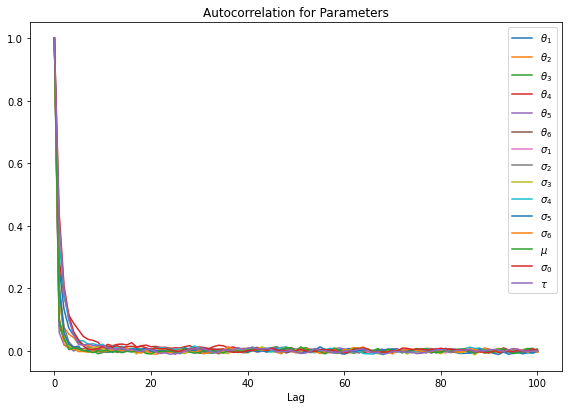

In [55]:
## Autocorrelation plots

fig = plt.figure(figsize=(8, 16))
ax1 = fig.add_subplot(3, 1, 3)
maxlag = 100 # maximum lag for autocorrelation
sampsc = P6_gibbs - P6_gibbs.mean(axis=0) # scale the samples by subtracting the mean
acorlags = np.arange(maxlag+1) # lags from 0 to maxlag

# calculate autocorrelation for all different lags
for i in range(P6_gibbs.shape[1]):
    auto = np.correlate(sampsc[:,i], sampsc[:,i], mode = 'full') 
    auto = auto[-len(sampsc):-len(sampsc)+maxlag+1] / auto[-len(sampsc)] 
    ax1.plot(acorlags, auto)
ax1.set_xlabel('Lag')
ax1.set_title('Autocorrelation for Parameters')
ax1.legend(np.concatenate([theta_titles,sigma_titles,hyper_titles]))
fig.tight_layout()

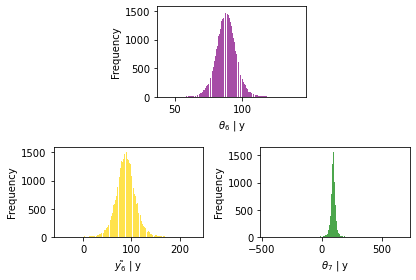

In [56]:
#Histograms of theta_6 |y, tilde y_6 | y, and theta_7 | y.

hier_hist = np.c_[P6_theta_gibbs[:,5],
                    norm.rvs(loc = P6_theta_gibbs[:,5], scale = P6_sigma_gibbs[:,5]),
                    norm.rvs(loc = P6_mu_gibbs, scale = P6_tau_gibbs)]

#Sets up grid for our three figures
ax1 = plt.subplot2grid(shape=(4,4), loc=(0,1), colspan=2,rowspan = 2)
ax2 = plt.subplot2grid((4,4), (2,0), colspan=2,rowspan = 2)
ax3 = plt.subplot2grid((4,4), (2,2), colspan=2,rowspan = 2)

ax = [ax1,ax2,ax3]
col = ['purple', 'gold','green']
posterior_labels = [r'$\theta_6$ | y',r'$\tilde{y_6}$ | y',r'$\theta_7$ | y']

for j in range(3):
    plt.tight_layout()
    ax[j].hist(x = hier_hist[:,j],bins='auto', color=col[j], alpha=0.7, rwidth=0.85)
    ax[j].set_ylabel("Frequency")
    ax[j].set_xlabel(posterior_labels[j])

### EXTRA CREDIT: PROBLEM 7 (BDA 3rd Ed., Exercise 13.5)
Estimating the number of unseen species (see Fisher, Corbet, and Williams, 1943, Efron
and Thisted, 1976, and Seber, 1992): suppose that during an animal trapping expedition
the number of times an animal from species i is caught is $x_i \sim Poisson(\lambda_i)$. For parts
(a)–(d) of this problem, assume a $Gamma(\alpha, \beta)$ prior distribution for the $\lambda_i's$, with a
uniform hyperprior distribution on $(\alpha,\beta)$. The only observed data are $y_k$, the number of
species observed exactly k times during a trapping expedition, for $k = 1, 2, 3,\dots$

> (a) Write the distribution $p(x_i \mid \alpha, \beta)$.

\begin{alignat*}{1}
p(x_j \mid \alpha, \beta) \propto \int p(x_j \mid \lambda_j) p(\lambda_j \mid \alpha, \beta) d\lambda_j &\propto  
\int  \frac{\lambda^{x_j}_j}{y_j!} e^{-\lambda_j}  \frac{\beta^{\alpha}}{\Gamma(\alpha)} \lambda^{\alpha-1}_j e^{-\beta \lambda_j}  d\lambda_j\\
&= Neg-Binom(x_j \mid r=\alpha,p =\frac{\beta}{\beta+1}) \\
\end{alignat*}

> (b) Use the distribution of $x_i$ to derive a multinomial distribution for y given that there
are a total of N species.

\begin{alignat*}{1}
p(y \mid \theta) &= \frac{N!}{\prod^{\infty}_{k=0} y_k!} \prod^{\infty}_{k=0} P(x_i = j \mid \alpha,\beta)^{y_k}  \\
&= \frac{N!}{\prod^{K}_{k=1} y_k!} \prod^{K}_{k=1} P(x_i = j \mid \alpha,\beta)^{y_k}  \\
\end{alignat*}

<Figure size 720x576 with 0 Axes>

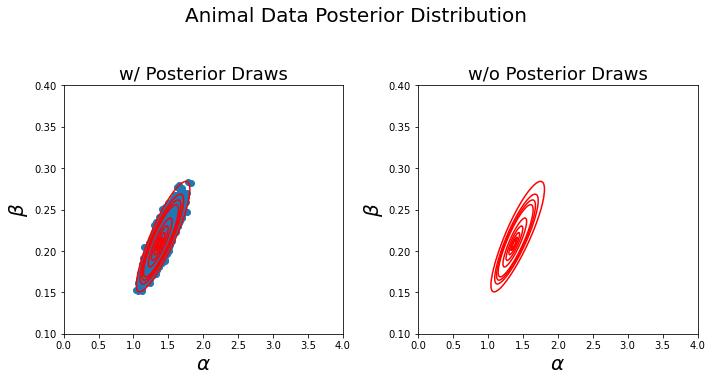

In [57]:

#data
captured = np.array([118,74,44,24,29,22,20,14,20,15,
                 12,14,6,12,6,9,9,6,10,10,11,5,3,3])
times = np.arange(1,25) 

#Grid for sampling
R = 1000
alphas = np.linspace(start = 0.0001, stop = 17, num = R)
betas = np.linspace(start = 0.0001, stop = 0.6, num = R)

ind_prior = lambda x,y :1
#Posterior Function. It is of form seen in derivation
def animal(w,y,prior):
    '''
    PARAMETERS:
    ----------
    w - alpha, beta parameter
    x - beta parameter
    y - number of species caught
    prior - prior on alpha, beta
    Returns:
    -------
    logpost : natural logarithm of unnormalized posterior density
    '''
    a,b = w[0], w[1]
    #prior distribution used for this problem
    logprior = np.log(prior(a,b))

    # for brevity, split the likelihood into a numerator term and denominator
    def loglik(a,b,x):
     l = gammaln(a+x) + a*np.log(b) - gammaln(a) - gammaln(x+1) - (x+a)*np.log1p(b)
     return l

    logpost = logprior + sum(y[j]*loglik(a,b,j+1) for j in range(len(y)) )
    return logpost

ani = animal(w=list([alphas[:,None],betas[:,None,None]]),
             y = captured,prior = ind_prior)

ani = np.sum(ani, axis=2)
ani = np.exp(ani - ani.max())

#Draw Samples via Grid Sampling (In python, probs need to sum to q)
ani = ani / ani.sum()

alpha_grid =  np.repeat(alphas,len(betas))
beta_grid = np.tile(betas,len(alphas))

N7 = 10000 #Number of Samples to draw
samples = np.random.choice(ani.size, size=N7, p = ani.ravel(order="F"))

#add some random jitter so the variables are continous random variables
d_alpha = np.diff(alphas)[0]/2
d_beta = np.diff(betas)[0]/2

a_post = alpha_grid[samples] -d_alpha + (d_alpha)*rand(N7)
b_post = beta_grid[samples] -d_beta + (d_beta)*rand(N7)

#plots contours and simulated points
plt.figure(figsize = (10, 8))

lev = [ 0.001, 0.01,.025,0.05,0.25,0.50,0.75,0.90,0.95]
cont = np.quantile(np.linspace(ani.min(),ani.max(),10000),lev)

fig, (ax3,ax4) = plt.subplots(1, 2,figsize=(10,5))

#contour w samples
ax3.contour(alphas, betas, ani, colors='red',levels=cont, zorder = 2)
ax3.scatter(a_post,b_post)
ax3.set_ylabel(r'$\beta$', fontsize = 20)
ax3.set_ylim(0.10,0.40)
ax3.set_xlabel( r'$\alpha$', fontsize = 20)
ax3.set_xlim(0,4)
ax3.set_title('w/ Posterior Draws', fontsize = 18)

#contour w/o samples
ax4.contour(alphas, betas, ani, colors='red',levels=cont, zorder = 2)
ax4.set_ylabel(r'$\beta$', fontsize = 20)
ax4.set_ylim(0.10,0.40)
ax4.set_xlabel( r'$\alpha$', fontsize = 20)
ax4.set_xlim(0,4)
ax4.set_title('w/o Posterior Draws', fontsize = 18)

fig.suptitle('Animal Data Posterior Distribution', y = 1.05,fontsize=20)
fig.tight_layout()

> (c) Suppose that we are given $y = (118, 74, 44, 24, 29, 22, 20, 14, 20, 15, 12, 14, 6, 12, 6,
9, 9, 6, 10, 10, 11, 5, 3, 3)$, so that 118 species were observed only once, 74 species were
observed twice, and so forth, with a total of 496 species observed and 3266 animals
caught. Write down the likelihood for y using the multinomial distribution with 24
cells (ignoring unseen species). Use any method to find the mode of $\alpha$, $\beta$ and an
approximate second derivative matrix.

In [58]:
#PART C
# initial guess
w0 = np.array([1,5])
# optimise
optim_res = optimize.minimize(lambda x: -animal(x,y=captured,prior = ind_prior),
                              x0 = w0,bounds = ((0.001,np.inf),(0.001,np.inf)))
# extract desired results
mu_p7 = optim_res['x']; S_7 = optim_res['hess_inv'].todense()
print(f"The mode of our posterior is {mu_p7}")
print(f"The Fisher Information (Covariance Matrix) associated with the mode is {S_7}")
np.linalg.eig(S_7)[0] #convince yourself I_w is positive definite


The mode of our posterior is [1.37253563 0.20844385]
The Fisher Information (Covariance Matrix) associated with the mode is [[0.01377906 0.0012895 ]
 [0.0012895  0.00042692]]


array([0.01390246, 0.00030352])

> (d) Derive an estimate and approximate 95\% posterior interval for the number of additional species that would be observed if 10,000 more animals were caught.

In [59]:
# PART D
B = [np.min(np.where(nbinom.rvs(n  = a_post, p = b_post/(1+b_post)).cumsum()>10000))
     for x in range(1000)]
extra_species = (np.percentile(np.array(B),[2.5,97.5])).round()
print(f"Our 95% CI for the additional number of species observed is {extra_species}")

Our 95% CI for the additional number of species observed is [1445. 1592.]


> (e) Evaluate the fit of the model to the data using appropriate posterior predictive checks.

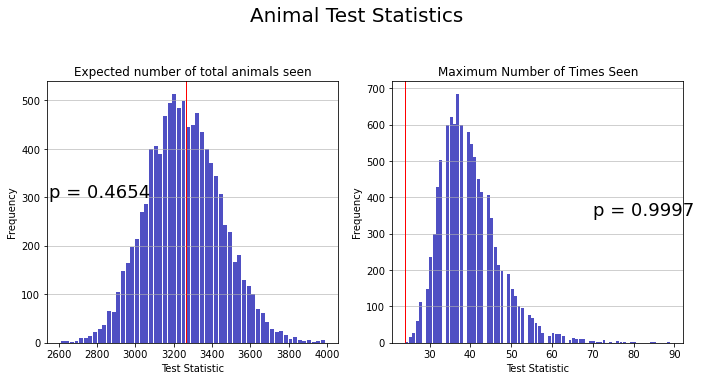

In [61]:
# PART E
#e Posterior Predictive Checks
animal_reps = nbinom.rvs(size = (10000,496), n = a_post[:,None], 
                 p = b_post[:,None]/(1+b_post[:,None]))

Test1 = animal_reps.sum(axis=1)
Test2 = animal_reps.max(axis=1)

fig, (ax3,ax4) = plt.subplots(1, 2,figsize=(10,5))

#(i) compare the sums
ax3.hist(x = Test1, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
ax3.grid(axis='y', alpha=0.75)
ax3.set_xlabel('Test Statistic')
ax3.set_ylabel('Frequency')
ax3.axvline((captured*times).sum(), color='red', linewidth=1)
ax3.text(2550, 300,'p = ' + str((Test1 > (captured*times).sum()).mean()), fontsize = 18)
ax3.set_title('Expected number of total animals seen')

#(ii)
ax4.hist(x = Test2, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
ax4.grid(axis='y', alpha=0.75)
ax4.set_xlabel('Test Statistic')
ax4.set_ylabel('Frequency')
ax4.axvline(max(times), color='red', linewidth=1)
ax4.text(70, 350,'p = ' + str((Test2 > max(times)).mean()), fontsize = 18)
ax4.set_title('Maximum Number of Times Seen')

fig.suptitle('Animal Test Statistics', y = 1.05,fontsize=20)
fig.tight_layout()

### PROBLEM 8 (Expectation Maximization Algorithm and Gibbs Sampling for Gaussian Mixture Model)

## EM Algorithm
> (a) EM Algorithm: Implement EM to find their MLE

In [62]:
### Problem 8

#set seed for reproducibility
np.random.seed(82)

#True parameter values
mu_true = np.array([0,-2,3])
sig_true = np.array([1,np.sqrt(2),4])
p_true = np.array([0.1,0.3,0.6])

r = np.random.choice(np.arange(len(mu_true)),size=120, p = p_true)
samples = norm(loc = mu_true[r], scale = sig_true[r]).rvs()

#mus, probs and sigmas should be initial guesses
def EM(samples, probs, mus, sigmas, tol):
    #initial log-likelihood
    n, m = len(samples), len(probs)
    count = 0
    
    ### NOTE: Calculate this external to the loop to save time
    
    #### E-step: Calculate the expectation of log p(y,z|theta)
        
    #calculating our weights
    w = probs*norm(mus, sigmas).pdf(samples[:,None])
    #weighting our weights
    w_tilde = w / w.sum(axis=1)[:,np.newaxis]
    #calculating Q(theta | theta^t)
    l_old = ( np.log(w.sum(axis=1)) ).sum()
    loglik = [l_old] #list so we can check algorithm is working properly
    while True:
        
        ### M-step: calculating our new MLE's
        
        #probability calculation
        probs  = w_tilde.sum(axis=0) / n
        
        #mean calculation
        mus = (w_tilde.T).dot(samples) / w_tilde.sum(axis=0)
        
        #standard deviation calculation
        mass = (w_tilde*(samples[:,None] - mus[np.newaxis,:])**2 ).sum(axis=0) 

        sigmas =  np.sqrt(mass / w_tilde.sum(axis=0))
        
        # update complete log likelihoood
        w = probs*norm(mus, sigmas).pdf(samples[:,None])
        w_tilde = w / w.sum(axis=1)[:,np.newaxis]

        #l_new = np.sum(W,axis = 1)
        #calculating Q(theta | theta^(t+1) )

        l_new = ( np.log(w.sum(axis=1)) ).sum()
                
        count +=1 #how many times it takes to reach convergence        
        if np.abs(l_new - l_old)  < tol:
            break
        l_old = l_new #so we don't have to repeatedly calculate l_old
        loglik.append(l_old)
    return count,loglik,probs, mus, sigmas 

init_p = np.array([1/2,1/4,1/4])  
init_mu = np.array([2,-1,0.7])
init_sigma = np.array([1,1,1])

t3 = time.time()
count,loglik,probs, mus,sigmas = EM(samples, init_p, init_mu, init_sigma,tol=1e-20)
t4 = time.time()

print(f"It took approximately {round(t4-t3,4)} seconds for this to run")

It took approximately 2.3088 seconds for this to run


It took approximately 1733 iterations to reach convergence
The MLE for the weights are [0.16125577 0.38829502 0.45044921]
The MLE for the means are [ 7.70078672 -2.35549079  1.60326189]
The MLE for the standard deviations are [3.03695987 1.49682317 2.4004322 ]


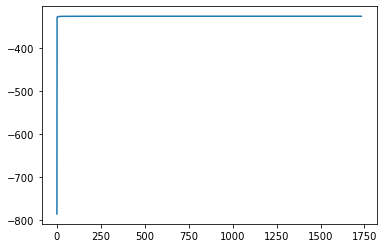

In [63]:

#check to make sure log-likelihood is monotonically decreasing
plt.plot(np.arange(count),np.array(loglik))
print(f"It took approximately {count} iterations to reach convergence")
print(f"The MLE for the weights are {probs}")
print(f"The MLE for the means are {mus}")
print(f"The MLE for the standard deviations are {sigmas}")

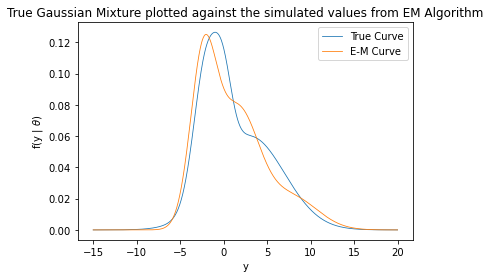

In [64]:
#Now let's see how our results work with

x_grid = np.linspace(start = -15, stop = 20, num = 1000)
true_curve = norm.pdf(x_grid[:,None],mu_true, sig_true).dot(p_true)
EMcurve_approx = norm.pdf(x_grid[:,None],mus, sigmas).dot(probs)

plt.plot(x_grid, true_curve, linewidth=0.8) # create lines for both theta1 and theta2 samples
plt.plot(x_grid, EMcurve_approx, linewidth=0.8) # create lines for both theta1 and theta2 samples
plt.title("True Gaussian Mixture plotted against the simulated values from EM Algorithm")
plt.xlabel("y")
plt.ylabel(r'f(y | $\theta$)')
plt.legend(['True Curve', 'E-M Curve'])
plt.show()

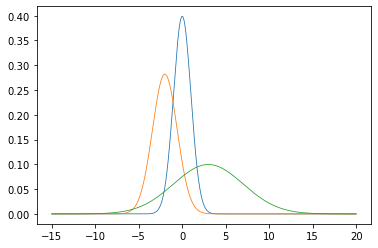

In [65]:
#plot of the histograms on top of each other
separates = norm.pdf(x = x_grid[:,None],loc = mu_true, scale = sig_true)
plt.plot(x_grid, separates, linewidth=0.8) # create lines for both theta1 and theta2 samples

## Gibbs Sampler
> (b) MCMC (Gibbs): use proper diffused prior $(p_i, \mu_i, \sigma^{2}_i)$ implement Gibbs 
algorithm to find the posterior distribution of $(p_i, \mu_i, \sigma^{2}_i)$.

In [66]:
#Gibbs Sampler Parameters

#mu posterior 
alpha = 3
#sigma posterior
eta, nu = 2, 2
eps = 0
# Number of iterations
N = 50000
#Number of mixtures to consider
n = len(mu_true)

# vectors to save our values
lmbda_gibbs,mu_gibbs,sigma_gibbs= [None]*N, [None]*N, [None]*N

lmbda = np.array([1/3,1/3,1/3])  
mu = np.array([2,-1,0.7])
sig = np.array([1,1,1])

t5 = time.time()
for i in range(N):
    #first get initial probabilities to draw z
    p = norm.pdf(x = samples[:,None], loc = mu, scale = sig)*lmbda
    p = p / p.sum(axis=1)[:,np.newaxis]
    
    #draw z for initial probabilities
    z = (p.cumsum(axis = 1) > rand(p.shape[0])[:,None]).argmax(axis=1)
    #How many values belong to 1, 2, and 3
    y_k = [samples[z==j] for j in range(n)]; n_k = np.array([len(x) for x in y_k])
    #draw lambda values, and append it to list
    lmbda = dirichlet.rvs(n_k+1, size=1).reshape(n,)
    lmbda_gibbs[i] = lmbda
    
    #draw mu values
    mu_gibbs_var = 1 / ((1/alpha)**2 + (n_k/sig**2) ) 
    mu_gibbs_mean = [sum(x) for x in y_k]/sig**2 + eps / alpha**2
    mu_gibbs_mean = mu_gibbs_mean*mu_gibbs_var
    
    mu = norm.rvs(loc = mu_gibbs_mean, scale = np.sqrt(mu_gibbs_var))
    mu_gibbs[i] = mu
    
    #draw sigma^2 values
    sums = np.array([sum( (y_k[x] - mu[x])**2 ) for x in range(n)])
    sig = np.sqrt( 1 / gamma.rvs(a = eta + 0.5*n_k, scale =  1/(nu + 0.5*sums)) )
    sigma_gibbs[i] = sig

t6 = time.time()
print(f"It took approximately {round(t6-t5,4)} seconds for this to run {N} samples")

It took approximately 27.0987 seconds for this to run 50000 samples


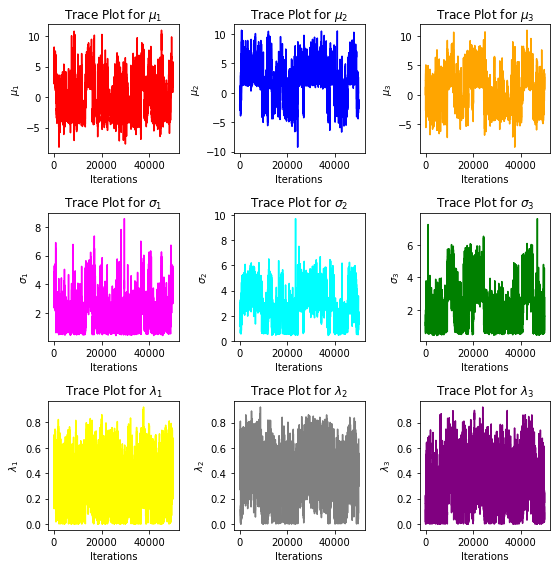

In [67]:
#change back to arrays for ease of use
lmbda_gibbs = np.array(lmbda_gibbs)
mu_gibbs = np.array(mu_gibbs)
sigma_gibbs = np.array(sigma_gibbs)

gibbs_samples = np.c_[mu_gibbs,sigma_gibbs,lmbda_gibbs]
colors = ['red','blue','orange',
          'magenta','cyan','green',
          'yellow','gray','purple']

titless = [r'$\mu_1$',r'$\mu_2$',r'$\mu_3$',
           r'$\sigma_1$',r'$\sigma_2$',r'$\sigma_3$',
           r'$\lambda_1$',r'$\lambda_2$',r'$\lambda_3$']

f,a = plt.subplots(3,3,figsize = (8,8))
a = a.ravel()
for idx,ax in enumerate(a):
    plt.tight_layout()
    ax.plot(gibbs_samples[:,idx], color = colors[idx])
    ax.set_title('Trace Plot for' + ' ' + titless[idx])
    ax.set_xlabel("Iterations")
    ax.set_ylabel(titless[idx])

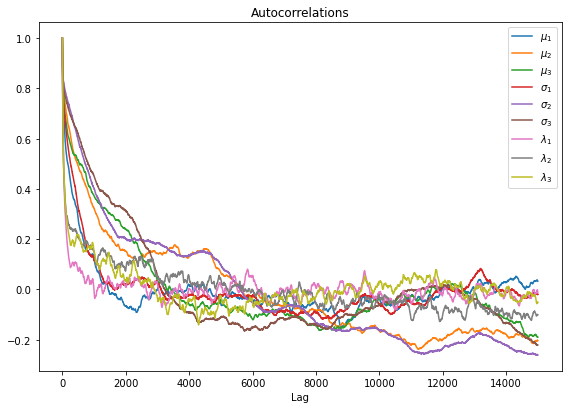

In [68]:
## Autocorrelation plots

fig = plt.figure(figsize=(8, 16))
ax1 = fig.add_subplot(3, 1, 3)
maxlag = 15000 # maximum lag for autocorrelation
sampsc = gibbs_samples - gibbs_samples.mean(axis=0) #scale samples by subtracting mean
acorlags = np.arange(maxlag+1) # lags from 0 to maxlag

# calculate autocorrelation for all different lags
for i in range(sampsc.shape[1]): # loop for parameters
    auto = np.correlate(sampsc[:,i], sampsc[:,i], mode = 'full')
    auto = auto[-len(sampsc):-len(sampsc)+maxlag+1] / auto[-len(sampsc)] 
    ax1.plot(acorlags, auto)
ax1.set_xlabel('Lag')
ax1.set_title('Autocorrelations')
ax1.legend(titless)
fig.tight_layout()

### EXTRA CREDIT: PROBLEM 9 (BDA 3rd Ed., Exercise 15.3)
Regression with many explanatory variables: Table 15.2 displays data from a designed experiment for a chemical process. In using these data to illustrate various approaches
to selection and estimation of regression coefficients, Marquardt and Snee (1975) assume a quadratic regression form; that is, a linear relation between the expectation of
the untransformed outcome, y, and the variables $x_1$, $x_2$, $x_3$, their two-way interactions,
$x_1 x_2$, $x_1 x_3$, $x_2 x_3$, and their squares, $x^2_1$, $x^2_2$, $x^2_3$.

> (a) Fit an ordinary linear regression model (that is, nonhierarchical with a uniform prior
distribution on the coefficients), including a constant term and the nine explanatory
variables above

In [77]:
#The data
#Reactor Temperature
x1 = np.array([1300,1300,1300,1300,1300,1300,1200,1200,1200,1200,
               1200,1200,1100,1100,1100,1100])
#Ratio of Hydrogen to n-heptane
x2 = np.array([7.5,9,11,13.5,17,23,5.3,7.5,11,13.5,17,23,5.3,7.5,11,17])
#contact time (sec)
x3 = np.array([0.012,0.012,0.0115,0.013,0.0135,0.012,0.04,0.038,0.032,0.026,
                0.034,0.041,0.084,0.098,0.092,0.086])
#conversion of heptane to acetlylene (%)
y = np.array([49,50.2,50.5,48.5,47.5,44.5,28,31.5,34.5,35,
              38,38.5,15,17,20.5,19.5])

#combine data into data matrix
X = np.c_[x1,x2,x3,x1*x2,x1*x3,x2*x3,x1**2,x2**2,x3**2]
#standardize our covariates for easier computation
X = (X-X.mean(axis=0)) / X.std(ddof=1,axis=0)
#add constant term
X_star = np.c_[np.ones(len(x1)),X]
#MLE
gram_mat = (X_star.T).dot(X_star); inv_gram_mat = np.linalg.inv(gram_mat)
MLE = inv_gram_mat.dot((X_star.T).dot(y))

#Number of simulations
N9 = 2000
#simulates sigma
s2 = ((y - X_star.dot(MLE)).T).dot((y - X_star.dot(MLE))) 
q = s2 / chi2.rvs(df = X_star.shape[0] - X_star.shape[1], size =  N9) #sigma^2
beta_post = [multivariate_normal.rvs(mean = MLE, cov = q[j]*inv_gram_mat)
             for j in range(N9)]
post_parameters = np.c_[np.array(beta_post),q]

names = ["Intercept","x1","x2","x3","x1x2","x1x3","x2x3","x1^2","x2^2","x3^2"]
param_names = np.concatenate([['\u03B2 '+str(j) for j in names],['\u03C3']])
part_a_stats = param_stats(X = post_parameters,
                           p = [0.025,0.25,0.50,0.75,0.975],
                           names = param_names, sig = 2)
part_a_stats

,Mean,Standard Deviation,2.5%,25.0%,50.0%,75.0%,97.5%
β Intercept,35.47,0.38,34.74,35.26,35.46,35.70,36.24
β x1,941.24,674.47,-335.94,536.66,948.89,1325.65,2333.31
β x2,178.80,41.87,94.78,154.19,178.62,203.38,262.84
β x3,826.29,567.86,-240.58,480.21,833.41,1145.90,2005.36
β x1x2,-164.67,39.77,-242.68,-188.16,-164.70,-141.75,-86.61
β x1x3,-670.58,477.70,-1652.52,-938.68,-676.36,-381.32,222.08
β x2x3,-22.46,6.14,-34.78,-26.19,-22.37,-18.97,-10.20
β x1^2,-844.66,631.15,-2144.83,-1208.74,-851.34,-472.56,344.35
β x2^2,-7.03,3.30,-13.80,-8.82,-7.00,-5.13,-1.04
β x3^2,-70.48,45.18,-163.48,-96.50,-71.86,-42.72,14.34


> (b) Fit a mixed-effects linear regression model with a uniform prior distribution on the
constant term and a shared normal prior distribution on the coefficients of the nine variables above. If you use iterative simulation in your computations, be sure to use
multiple sequences and monitor their joint convergence.

In [74]:
### PART B

K = 100000 #How many values we want to draw up

#list to append our samples to
beta_gibbs = [None]*K
sigma_gibbs = [None]*K
mu_gibbs = [None]*K
tau_gibbs = [None]*K

#initial values
beta = MLE #This is good as any guess
mu = beta.mean()

#helpful things
N,J = X_star.shape[0], X_star.shape[1]
a = 1 #this represent how many values have improper prior

y_tilde = (y.T).dot(X_star) # do this beforehand so we don't have to do this N9 times
Id = np.concatenate([np.zeros(a),np.ones(J-a)]); Id_mat = np.diag(Id)

t1 = time.time()
for j in range(K):
    
    # Sigma draws
    s2 = ((y - X_star.dot(beta) ).T).dot( y - X_star.dot(beta) )
    sigma = np.sqrt( s2 / chi2(df = N ).rvs() )
    sigma_gibbs[j] = sigma
    
    # Tau draw
    tau = np.sqrt( ((beta[a:] - mu)**2).sum() / chi2(df = J - a).rvs() )
    tau_gibbs[j] = tau

    # Theta draws
    V_beta = np.linalg.inv(Id_mat/tau**2 + gram_mat/sigma**2)
    beta_tilde = V_beta.dot(Id*(mu/tau**2) + y_tilde/sigma**2)
    beta = multivariate_normal(mean=beta_tilde, cov=V_beta).rvs()
    beta_gibbs[j] = beta
    
    # Mu Draw
    mu = norm(loc = (beta[a:]).mean(),scale = tau / np.sqrt(J-a)).rvs()
    mu_gibbs[j] = mu
    
t2 = time.time()
print(f"It took approximately {round(t2-t1,4)} seconds for this to run {K} samples")

beta_gibbs = np.array(beta_gibbs)
sigma_gibbs = np.array(sigma_gibbs)
mu_gibbs = np.array(mu_gibbs)
tau_gibbs = np.array(tau_gibbs)

Mixed_Model_gibbs = np.c_[beta_gibbs,sigma_gibbs,mu_gibbs,tau_gibbs]
MM_titles = np.concatenate([['\u03B2'+str(j) for j in range(0,J)],
                                ['\u03C3','\u03BC','\u03C4']])
param_stats(X = Mixed_Model_gibbs[-int(0.4*K):,],
                       p = [0.025,0.25,0.50,0.75,0.975],
                       names = MM_titles, sig = 2)

It took approximately 355.7412 seconds for this to run 100000 samples


,Mean,Standard Deviation,2.5%,25.0%,50.0%,75.0%,97.5%
β0,35.48,0.69,34.10,35.04,35.48,35.91,36.87
β1,5.22,4.73,-3.63,2.58,5.05,7.69,14.88
β2,2.16,4.94,-6.34,-0.68,1.78,4.52,12.82
β3,-2.17,5.26,-13.02,-4.92,-2.06,0.69,8.01
β4,0.25,4.74,-9.44,-2.12,0.43,2.89,9.02
β5,-1.82,4.97,-11.50,-4.61,-1.89,0.86,8.40
β6,2.55,1.86,-1.18,1.37,2.58,3.75,6.20
β7,4.88,4.53,-4.08,2.45,4.89,7.36,13.83
β8,-2.67,3.03,-8.93,-4.57,-2.55,-0.68,3.06
β9,-0.03,3.32,-6.54,-2.07,-0.09,1.92,6.82


> (d) Repeat (a), but with a $t_4$ prior distribution on the nine variables.

t4 prior

In [75]:
### PART D

K = 100000 #How many values we want to draw up

#list to append our samples to
beta_gibbs = [None]*K
sigma_gibbs = [None]*K
lmbda_gibbs = [None]*K

#initial values
beta = MLE #This is good as any guess

#helpful things
N,J = X_star.shape[0], X_star.shape[1]
a = 1 #this represent how many values have improper prior
nu,mu, tau = 4 ,0,1 #t distribution parameters
y_tilde = (y.T).dot(X_star) # do this beforehand so we don't have to do this N9 times
Id = np.concatenate([np.zeros(a),np.ones(J-a)]); Id_mat = np.diag(Id)

t1 = time.time()
for j in range(K):
    
    # Sigma draws
    s2 = ((y - X_star.dot(beta) ).T).dot( y - X_star.dot(beta) )
    sigma = np.sqrt( s2 / chi2(df = N ).rvs() )
    sigma_gibbs[j] = sigma
    
    # Lambda draw
    lmbda_hat_sq = ((beta[a:] - mu)**2).sum() + nu*tau**2
    lmbda = np.sqrt( lmbda_hat_sq / chi2(df = nu+J).rvs() )
    lmbda_gibbs[j] = lmbda

    # Theta draws
    V_beta = np.linalg.inv(Id_mat/lmbda**2 + gram_mat/sigma**2)
    beta_tilde = V_beta.dot(Id*(mu/lmbda**2) + y_tilde/sigma**2)
    beta = multivariate_normal(mean=beta_tilde, cov=V_beta).rvs()
    beta_gibbs[j] = beta
    
t2 = time.time()
print(f"It took approximately {round(t2-t1,4)} seconds for this to run {K} samples")

beta_gibbs = np.array(beta_gibbs)
sigma_gibbs = np.array(sigma_gibbs)
lmbda_gibbs = np.array(lmbda_gibbs)

tprior_gibbs = np.c_[beta_gibbs,sigma_gibbs,lmbda_gibbs]
tprior_titles = np.concatenate([['\u03B2'+str(j) for j in range(0,J)],
                            ['\u03C3','\u03BB']])
param_stats(X = tprior_gibbs[-int(0.4*K):,],
                            p=[0.025,0.25,0.50,0.75,0.975],
                            names = tprior_titles, sig = 2)

It took approximately 315.1677 seconds for this to run 100000 samples


,Mean,Standard Deviation,2.5%,25.0%,50.0%,75.0%,97.5%
β0,35.48,0.76,33.98,35.01,35.48,35.95,36.98
β1,4.07,2.37,-0.30,2.53,3.95,5.49,9.03
β2,0.99,2.31,-3.44,-0.46,0.93,2.34,5.80
β3,-2.12,2.52,-7.25,-3.62,-2.07,-0.59,2.83
β4,0.66,2.29,-3.93,-0.72,0.66,2.05,5.25
β5,-2.21,2.47,-7.21,-3.69,-2.20,-0.72,2.68
β6,1.51,1.73,-1.91,0.35,1.53,2.69,4.84
β7,4.14,2.29,-0.11,2.65,4.05,5.54,8.93
β8,-1.36,2.09,-5.79,-2.65,-1.25,0.04,2.47
β9,-0.41,1.99,-4.20,-1.72,-0.47,0.82,3.74


Generalized t4 prior

In [76]:
# Generalized t4 prior
#list to append our samples to
beta_gibbs2 = [None]*K
sigma_gibbs2 = [None]*K
lmbda_gibbs2 = [None]*K
mu_gibbs = [None]*K
tau_gibbs = [None]*K

#initial values
beta = MLE #This is good as any guess
lmbda = 3
mu = beta.mean()

def tau_pdf(x,df,s): 
     p = (df/2)*np.log(x) - ( (df*x)/2)*(1/s**2)
     return p
#Grid for sigma 0 and nu
tau_grid = np.linspace(start = 1, stop = 500, num = 2000)
d_tau = np.diff(tau_grid)[0]/2

#helpful things
N,J = X_star.shape[0], X_star.shape[1]
a = 1 #this represent how many values have improper prior
nu = 4 #t distribution parameters
y_tilde = (y.T).dot(X_star) # do this beforehand so we don't have to do this N9 times
Id = np.concatenate([np.zeros(a),np.ones(J-a)]); Id_mat = np.diag(Id)

t1 = time.time()
for j in range(K):
    
    # Sigma draws
    s2 = ((y - X_star.dot(beta) ).T).dot( y - X_star.dot(beta) )
    sigma = np.sqrt( s2 / chi2(df = N ).rvs() )
    sigma_gibbs2[j] = sigma
    
    # tau draws
    tau_p = tau_pdf(x=tau_grid,df = nu,s = sigma)
    tau_p = np.exp(tau_p) / (np.exp(tau_p)).sum()
    tau = np.sqrt( np.random.choice(tau_grid,p = tau_p) + (d_tau)*rand() )
    tau_gibbs[j] = tau

    # Lambda draw
    lmbda_hat_sq = ((beta[a:] - mu)**2).sum() + nu*tau**2
    lmbda = np.sqrt( lmbda_hat_sq / chi2(df = nu+J).rvs() )
    lmbda_gibbs2[j] = lmbda
    
    # Mu Draw
    mu = norm(loc = (beta[1:]).mean(),scale = tau / np.sqrt(J)).rvs()
    mu_gibbs[j] = mu

    # Beta draws
    V_beta = np.linalg.inv(Id_mat/lmbda**2 + gram_mat/sigma**2)
    beta_tilde = V_beta.dot(Id*(mu/lmbda**2) + y_tilde/sigma**2)
    beta = multivariate_normal(mean=beta_tilde, cov=V_beta).rvs()
    beta_gibbs2[j] = beta
    
t2 = time.time()
print(f"It took approximately {round(t2-t1,4)} seconds for this to run {K} samples")

beta_gibbs2 = np.array(beta_gibbs2)
sigma_gibbs2 = np.array(sigma_gibbs2)
lmbda_gibbs2 = np.array(lmbda_gibbs2)
mu_gibbs = np.array(mu_gibbs)
tau_gibbs = np.array(tau_gibbs)

gtprior_gibbs = np.c_[beta_gibbs2,sigma_gibbs2,lmbda_gibbs2,mu_gibbs,tau_gibbs]

gtprior_titles = np.concatenate([['\u03B2'+str(j) for j in range(0,J)],
                            ['\u03C3','\u03BB','\u03BC','\u03C4']])

param_stats(X = gtprior_gibbs[-int(0.4*K):,],
                            p=[0.025,0.25,0.50,0.75,0.975],
                            names = gtprior_titles, sig = 2)

It took approximately 604.7324 seconds for this to run 100000 samples


,Mean,Standard Deviation,2.5%,25.0%,50.0%,75.0%,97.5%
β0,35.48,0.69,34.11,35.05,35.48,35.91,36.85
β1,4.95,3.19,-1.22,2.95,4.89,6.90,11.62
β2,1.40,3.18,-4.67,-0.60,1.30,3.32,8.00
β3,-1.93,3.50,-9.05,-4.05,-1.89,0.25,4.93
β4,0.61,3.11,-5.70,-1.30,0.62,2.55,6.73
β5,-1.93,3.45,-8.79,-4.06,-1.95,0.20,4.98
β6,2.37,1.71,-1.07,1.27,2.37,3.49,5.73
β7,4.87,3.06,-1.22,2.96,4.85,6.77,11.01
β8,-2.13,2.54,-7.33,-3.74,-2.07,-0.49,2.81
β9,-0.19,2.55,-5.25,-1.82,-0.22,1.41,5.01
